# Business Context

Rossmann is an european drugstore chain. The C-suite decided it is time to renew and refurbish the stores. In order to do that, the C-suite wants to know the estimated amount of sales each store wiil have at the end of 6 weeks. With this value, they can elaborate a plan to proceed with the renovations without compromising the budget of each store.

The C-suite asked for the predictions of sales of each store for the next 6 weeks and the worst and best scenario of sales during the same period, for each store and for all stores.

# 0. Imports

## 0.1 Helper Functions

In [2]:
# data manipulation
import math
import inflection
import datetime
from tabulate import tabulate
import pandas as pd
import numpy as np

# EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# data preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import xgboost as xgb

# model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats

# API
import random
import warnings
import requests
import pickle

In [3]:
# sets seaborn default style
sns.set()

# sets matplolit inline
%matplotlib inline

# sets to display unlimited number of columns
pd.options.display.max_columns = 70

# setting the title and axis labels
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

# ignores warnings
warnings.filterwarnings('ignore')

# cramér V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # gets the rows, cols
    r, k = confusion_matrix.shape
    
    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

# mean absolute percentage error (MAPE)
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

# calculates the errors
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

# mean percentage error (MPE)
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

# makes de cross validation for a given model
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    # creates empty lists to store the metrics
    mae_list = []
    mape_list = []
    rmse_list = []

    # runs the KFold
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # gets the final date and subtracts 6 weeks
        validation_start_date = x_training['date_x'].max() - datetime.timedelta(days=k * 7 * 6)

        # gets the final date
        validation_end_date = x_training['date_x'].max() - datetime.timedelta(days=(k-1) * 7 * 6)

        # filters dataset
        training = x_training[x_training['date_x'] < validation_start_date]
        validation = x_training[(x_training['date_x'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # traning and validation dataset
        # training
        xtraining = training.drop(['date_x','sales','date'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation= validation.drop(['date_x','sales','date'], axis=1)
        yvalidation = validation['sales']

        # model
        m_regression = model.fit(xtraining, ytraining)

        # prediction
        yhat = m_regression.predict(xvalidation)

        # performance
        regression_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # stores the performance of each KFold iteration
        mae_list.append(regression_result['MAE'])
        mape_list.append(regression_result['MAPE'])
        rmse_list.append(regression_result['RMSE'])

    # calculates the mean from the errors : the real metric for the algorithm
    # and creates a DataFrame to organize the data
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +- ' + np.round(np.std(rmse_list), 2).astype(str)}, 
                       index=[0])

In [4]:
from IPython.display import HTML
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 40
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    pd.set_option( 'display.expand_frame_repr', False ) 
    pd.options.display.float_format = '{:,.6f}'.format
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Files

In [5]:
df_sales = pd.read_csv('../database/train.csv',low_memory=False)
df_stores = pd.read_csv('../database/store.csv',low_memory=False)
df = pd.merge (df_sales, df_stores, how='left', on='Store')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,"1,270.000000",9.000000,"2,008.000000",0,nan,nan,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000000,11.000000,"2,007.000000",1,13.000000,"2,010.000000","Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,"14,130.000000",12.000000,"2,006.000000",1,14.000000,"2,011.000000","Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000000,9.000000,"2,009.000000",0,nan,nan,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,"29,910.000000",4.000000,"2,015.000000",0,nan,nan,NaN


# 1. Data Description

In [6]:
df1 = df.copy()

In [7]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,"1,270.000000",9.000000,"2,008.000000",0,nan,nan,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000000,11.000000,"2,007.000000",1,13.000000,"2,010.000000","Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,"14,130.000000",12.000000,"2,006.000000",1,14.000000,"2,011.000000","Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000000,9.000000,"2,009.000000",0,nan,nan,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,"29,910.000000",4.000000,"2,015.000000",0,nan,nan,NaN


## 1.1 Rename Columns

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list (map(snakecase,cols_old))

df1.columns=cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [11]:
print ('Number of rows: {}'.format (df1.shape[0]))
print ('Number of columns: {}'.format (df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Metadata

| Variable | Description  | Data Type |
|--|--|--|
| Store | Unique Id for each store | categorical |
| Day of Week | Represents the day of week the sale happened | categorical |
| Sales | Turnover for any given day (target variable) | numerical continuous |
| Customers | Number of customers on a given day | numerical continuous |
| Open |  Flag - Indicator for whether the store was open: 0 = closed, 1 = open | binary |
| StateHoliday | Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None | categorical |
| SchoolHoliday | Flag - Indicates if the (Store, Date) was affected by the closure of public schools | binary |
| StoreType | Differentiates between 4 different store models: a, b, c, d | categorical |
| Assortment | Describes an assortment level: a = basic, b = extra, c = extended | categorical |
| CompetitionDistance | Distance in meters to the nearest competitor store |  numerical continuous |
| CompetitionOpenSince[Month/Year] |Approximate year and month of the time the nearest competitor was opened| date |
| Promo | Flag - indicates whether a store is running a promo on that day | binary |
| Promo2 | Flag - Promo2 is a promotion that happens during all year in some stores: 0 = store is not participating, 1 = store is participating | binary |
| Promo2Since[Year/Week] | Year and calendar week when the store started participating in Promo2 | date |
| PromoInterval | Promo2 happens during all year but is update every 3 months. This variable indicates when the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store | categorical |

## 1.3 Data Types

In [12]:
df1.dtypes

store                           int64  
day_of_week                     int64  
date                            object 
sales                           int64  
customers                       int64  
open                            int64  
promo                           int64  
state_holiday                   object 
school_holiday                  int64  
store_type                      object 
assortment                      object 
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                          int64  
promo2_since_week               float64
promo2_since_year               float64
promo_interval                  object 
dtype: object

In [13]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 NA Values

In [14]:
df1.isna().sum()#/len(df1)*100

store                           0     
day_of_week                     0     
date                            0     
sales                           0     
customers                       0     
open                            0     
promo                           0     
state_holiday                   0     
school_holiday                  0     
store_type                      0     
assortment                      0     
competition_distance            2642  
competition_open_since_month    323348
competition_open_since_year     323348
promo2                          0     
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.4.1 Fill NA Values

#### 1.4.1.1 Competition Distance

First, let's check what stores don't have any input for this variable.

- If there are records of a store with and without Competition Distance, it may be an error from the person that collect the data. For this case, we could (a) fill the NA values with the same Competition Distance or (b) assume the hypothesis that if there are records starting from a certain date, in the previous period the store didn't have competition nearby. In both cases, the first thing to do would be contact the client and ask for some documentation or guidance.

- If the a store doesn't have any Competition Distance defined, we will set a much higher value than the maximun value, assuming the competition far away. If we inputed a 0, that could cause problems in interpretation, as a 0 can mean that the competition store is even closer that stores with Competition Distance = 1, for example.

In [15]:
df1[pd.isnull(df1['competition_distance'])].groupby('store')['store'].count()

store
291    942
622    942
879    758
Name: store, dtype: int64

In [16]:
df1[df1['store']==879]['competition_distance'].isna().sum()
#The same 3 stores do not have competition distance - 291. 622, 879 - and none of them have this value lsited

758

In [17]:
df1['competition_distance'].max() # = 75860.0

75860.0

In [18]:
df1['competition_distance']= df1['competition_distance'].fillna(200000)

#### 1.4.1.2 Competition Open Since Month / Competition Open Since Year

We can fill the NA values with the date from sales' date or we can input the oldest sale data from each store

In [19]:
#Let's take a look in which stores don't have any values for the variables
df1['store'][df1['competition_open_since_month'].isna()].value_counts()

767    942
101    942
871    942
105    942
617    942
      ... 
637    758
893    758
132    758
909    758
512    758
Name: store, Length: 354, dtype: int64

In [20]:
df1['store'][df1['competition_open_since_year'].isna()].value_counts()

767    942
101    942
871    942
105    942
617    942
      ... 
637    758
893    758
132    758
909    758
512    758
Name: store, Length: 354, dtype: int64

In [21]:
#It seems they are the same stores
df1['store'][df1['competition_open_since_year'].isna() & df1['competition_open_since_month'].isna()].value_counts()

767    942
101    942
871    942
105    942
617    942
      ... 
637    758
893    758
132    758
909    758
512    758
Name: store, Length: 354, dtype: int64

In [22]:
l=(df1['store'][df1['competition_open_since_year'].isna()]).values.tolist()

In [23]:
# And none of the stores has the month and year in any record
df1['competition_open_since_month'][df1['store'].isin(l)].value_counts()

Series([], Name: competition_open_since_month, dtype: int64)

Calculating oldest sale for each store

In [24]:
a=df1[['store','date']].groupby(['store']).min()

In [25]:
df1=pd.merge(df1, a, on='store', how='outer')

In [26]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date_y'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date_y'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#### 1.4.1.3 Promo2 Since Week / Promo2 Since Year

First, let's see if the rows with NA are participating of Promo2

In [27]:
df1[df1['promo2']==1 & df1['promo2_since_week'].isna()]

,store,day_of_week,date_x,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,date_y


In [28]:
df1[df1['promo2']==1 & df1['promo2_since_year'].isna()]

,store,day_of_week,date_x,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,date_y


As there isn't any store participating in Promo2, we will set NA to 0

In [29]:
df1['promo2_since_year'].fillna(value=0,inplace=True)
df1['promo2_since_week'].fillna(value=0,inplace=True)

#### 1.4.1.4 Promo Interval

Promo Interval refers to when Promo2 is renewed. Let's check if the NaN rows are participating of Promo2

In [30]:
df1[df1['promo_interval'].isna()]['promo2'].value_counts(dropna = True)
# If zero is the unique value, NaN values on 'promo_interval' are consistent with 'promo2'=0 and we can fill the NaN with 0

0    508031
Name: promo2, dtype: int64

In [31]:
# We will fill in the NaN with zeroes
df1['promo_interval'].fillna(0, inplace=True)

#### Rechecking NA

In [32]:
df1.isna().sum()

store                           0
day_of_week                     0
date_x                          0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
date_y                          0
dtype: int64

## 1.5 Change Data Types

In [33]:
df1.dtypes

store                           int64         
day_of_week                     int64         
date_x                          datetime64[ns]
sales                           int64         
customers                       int64         
open                            int64         
promo                           int64         
state_holiday                   object        
school_holiday                  int64         
store_type                      object        
assortment                      object        
competition_distance            float64       
competition_open_since_month    float64       
competition_open_since_year     float64       
promo2                          int64         
promo2_since_week               float64       
promo2_since_year               float64       
promo_interval                  object        
date_y                          datetime64[ns]
dtype: object

In [34]:
# transforms competition data to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# transforms promotion data to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                           int64         
day_of_week                     int64         
date_x                          datetime64[ns]
sales                           int64         
customers                       int64         
open                            int64         
promo                           int64         
state_holiday                   object        
school_holiday                  int64         
store_type                      object        
assortment                      object        
competition_distance            float64       
competition_open_since_month    int32         
competition_open_since_year     int32         
promo2                          int64         
promo2_since_week               int32         
promo2_since_year               int32         
promo_interval                  object        
date_y                          datetime64[ns]
dtype: object

* Note: data wasn't separated into training and test before as the transformations in this section would not have impact in prediction or data leakage

In [35]:
#y = df1['sales']
#X = df1.drop(labels='sales',axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
train_set, test_set = train_test_split(df1, test_size=0.3, random_state=42)

In [37]:
train_set

,store,day_of_week,date_x,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,date_y
817013,897,4,2015-07-02,3513,314,1,1,0,0,c,c,"3,290.000000",1,2007,1,5,2013,"Feb,May,Aug,Nov",2013-01-01
861474,946,1,2015-02-09,3858,543,1,0,0,0,a,a,"2,220.000000",12,2011,1,14,2015,"Jan,Apr,Jul,Oct",2013-01-01
772779,848,5,2013-10-04,6230,803,1,0,0,0,a,c,370.000000,7,2007,1,14,2011,"Jan,Apr,Jul,Oct",2013-01-01
81436,90,6,2015-02-07,7884,1034,1,0,0,0,a,a,330.000000,11,2007,0,0,0,0,2013-01-01
862893,947,7,2013-10-20,0,0,0,0,0,0,a,a,460.000000,3,2014,1,13,2010,"Jan,Apr,Jul,Oct",2013-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,286,2,2014-10-28,3655,378,1,0,0,0,a,a,"1,460.000000",4,2015,0,0,0,0,2013-01-01
365838,401,5,2013-11-08,7779,700,1,1,0,0,a,c,"9,200.000000",10,2009,1,14,2012,"Jan,Apr,Jul,Oct",2013-01-01
131932,146,3,2014-09-24,5349,578,1,0,0,0,d,c,"8,050.000000",10,1961,1,48,2012,"Jan,Apr,Jul,Oct",2013-01-01
671155,737,2,2013-04-09,7079,1048,1,1,0,0,a,a,100.000000,5,2007,1,31,2013,"Jan,Apr,Jul,Oct",2013-01-01


## 1.6 Descriptive Statisctics

In [38]:
num_attributes = train_set.select_dtypes( include = ['int64', 'float64','int32'])
cat_attributes = train_set.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]','int32'])

### 1.6.1 Numerical Variables

#### Visualizations

In [39]:
d1 = num_attributes.describe().T
d2 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d3 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
d5 = pd.concat([d2,d3,d4]).T.reset_index()
d5.columns = ['variable','range','kurtosis', 'skew']
ds_num = d5.join(d1,on='variable')
ds_num

,variable,range,kurtosis,skew,count,mean,std,min,25%,50%,75%,max
0,store,"1,114.000000",-0.001102,-1.200047,"712,046.000000",558.387145,321.892006,1.000000,281.000000,558.000000,837.000000,"1,115.000000"
1,day_of_week,6.000000,0.001158,-1.247254,"712,046.000000",3.998039,1.997762,1.000000,2.000000,4.000000,6.000000,7.000000
2,sales,"41,551.000000",0.641674,1.772242,"712,046.000000","5,776.150663","3,852.058952",0.000000,"3,728.000000","5,746.000000","7,856.000000","41,551.000000"
3,customers,"5,494.000000",1.592174,7.021360,"712,046.000000",633.255461,464.275987,0.000000,405.000000,609.000000,837.000000,"5,494.000000"
4,open,1.000000,-1.758375,1.091886,"712,046.000000",0.830142,0.375509,0.000000,1.000000,1.000000,1.000000,1.000000
5,promo,1.000000,0.487893,-1.761966,"712,046.000000",0.381502,0.485756,0.000000,0.000000,0.000000,1.000000,1.000000
6,school_holiday,1.000000,1.676327,0.810076,"712,046.000000",0.178817,0.383199,0.000000,0.000000,0.000000,0.000000,1.000000
7,competition_distance,"199,980.000000",10.247866,148.305757,"712,046.000000","5,929.904739","12,509.317161",20.000000,710.000000,"2,330.000000","6,910.000000","200,000.000000"
8,competition_open_since_month,11.000000,0.311675,-1.422163,"712,046.000000",5.247199,3.928505,1.000000,1.000000,4.000000,9.000000,12.000000
9,competition_open_since_year,115.000000,-7.942198,141.153729,"712,046.000000","2,010.055751",5.351759,"1,900.000000","2,008.000000","2,012.000000","2,013.000000","2,015.000000"


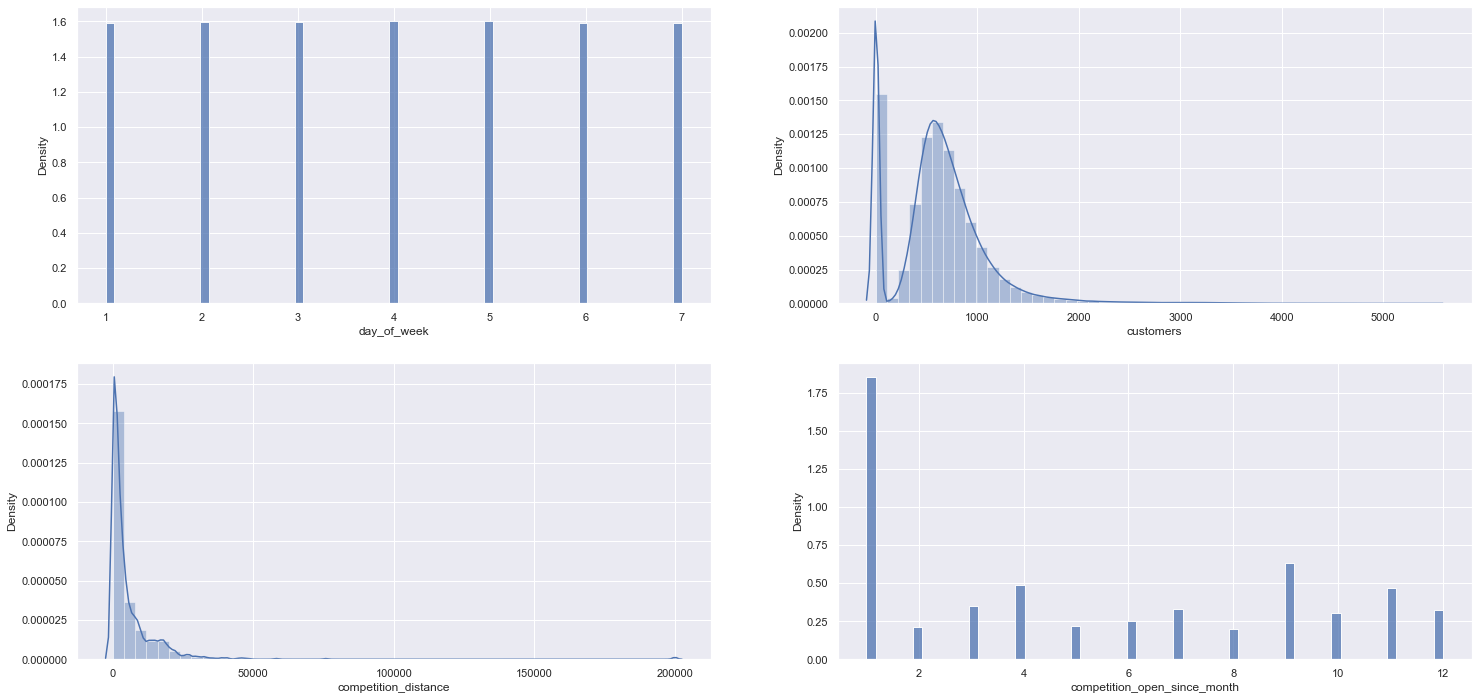

In [40]:
plt.subplot(2, 2, 1)
ax = sns.histplot(data=train_set['day_of_week'],stat='density')

plt.subplot(2, 2, 2)
ax = sns.distplot(train_set['customers'])

plt.subplot(2, 2, 3)
ax = sns.distplot(train_set['competition_distance'])

plt.subplot(2, 2, 4)
ax = sns.histplot(data=train_set['competition_open_since_month'],stat='density')

plt.show()

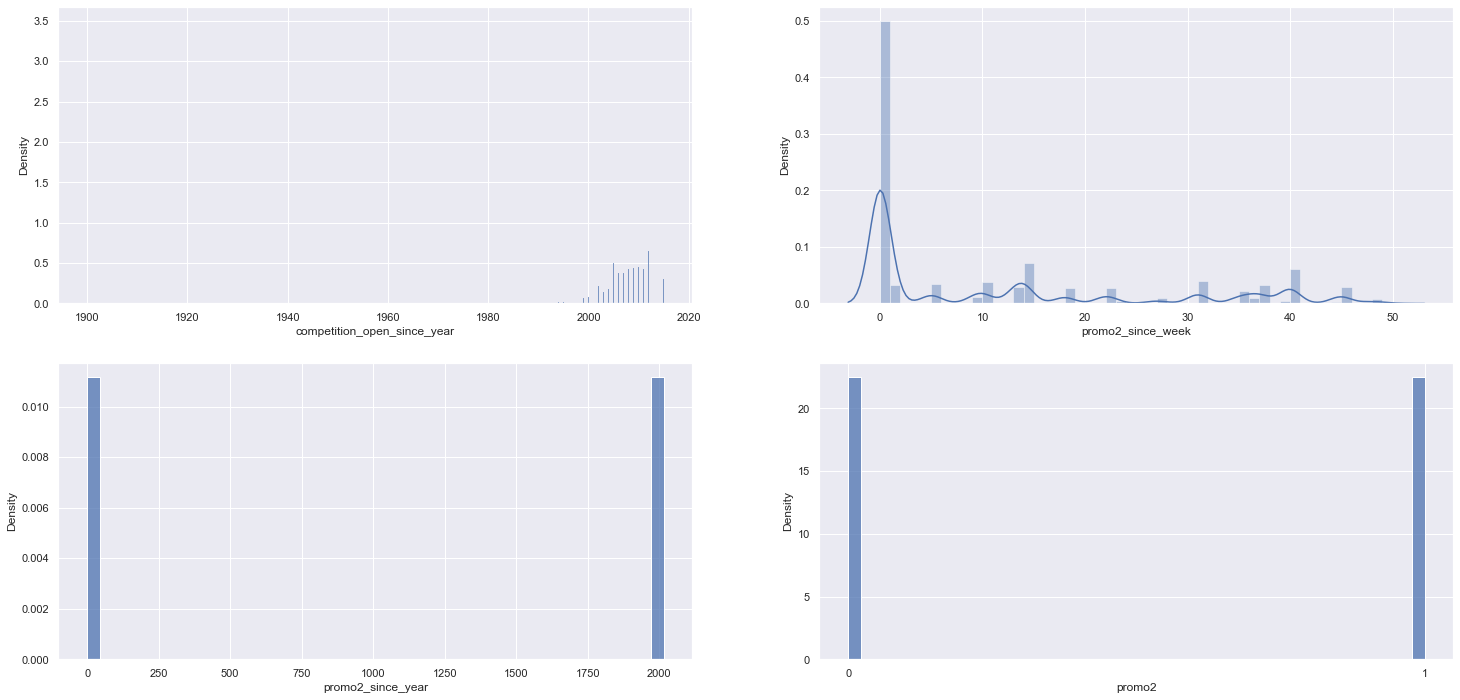

In [41]:
plt.subplot(2, 2, 1)
ax = sns.histplot(train_set['competition_open_since_year'],stat='density')

plt.subplot(2, 2, 2)
ax = sns.distplot(train_set['promo2_since_week'])

plt.subplot(2, 2, 3)
ax = sns.histplot(train_set['promo2_since_year'],stat='density')

plt.subplot(2, 2, 4)
ax = sns.histplot(train_set['promo2'],stat='density')
plt.xticks([0, 1]);

plt.show()

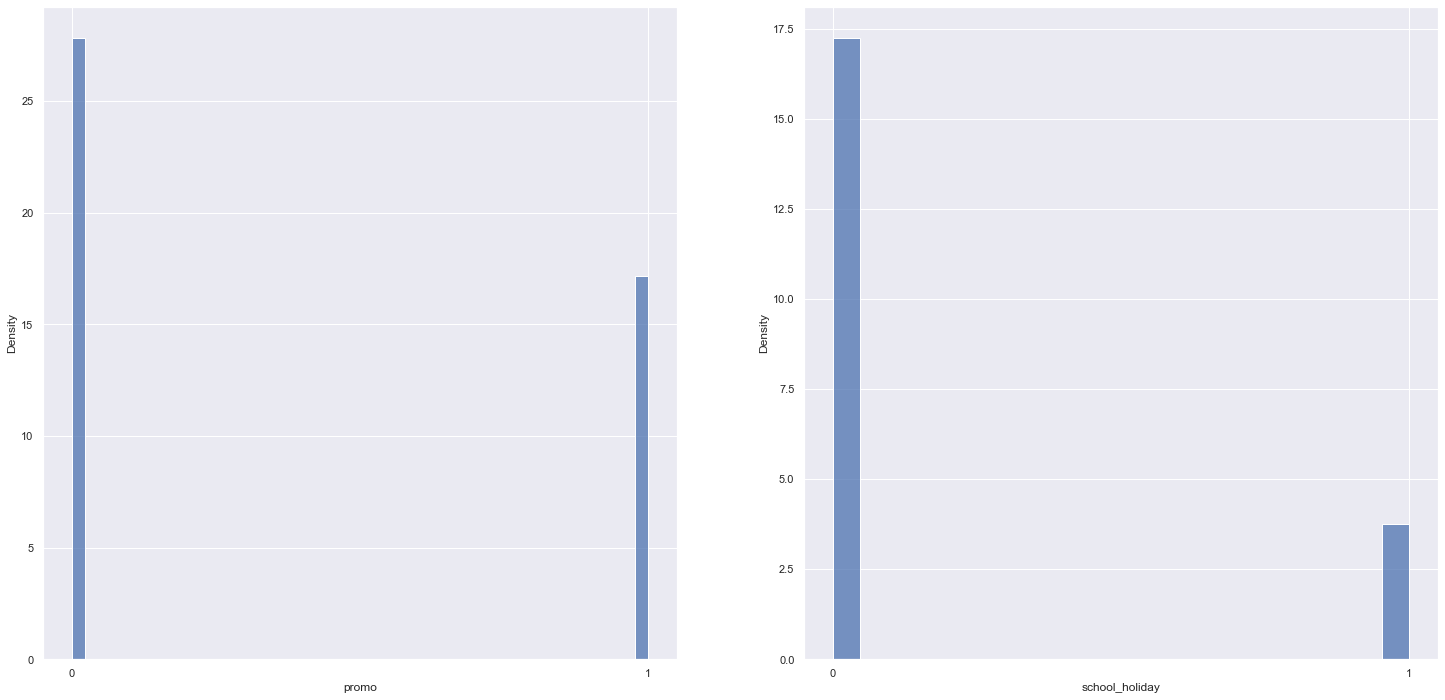

In [42]:
plt.subplot(1, 2, 1)
ax = sns.histplot(train_set['promo'],stat='density')
plt.xticks([0, 1]);

plt.subplot(1, 2, 2)
ax = sns.histplot(train_set['school_holiday'],stat='density')
plt.xticks([0, 1]);

plt.show()

#### Target Variable

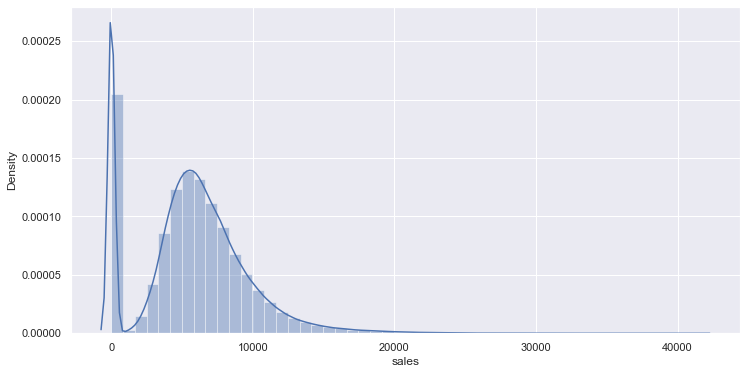

In [43]:
# plots distribution
ax = sns.distplot(df1['sales'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# displays plot
plt.show()

#### Conclusions

**Store** - There are 1114 stores <br>
**Sales** - The average of 5776 dolars and a std of 3852 dolars - The skew and kurtosis are positive, meaning the with a tendency of the tail ranging slight more to the right (higher sales) and there is a peak in the distribution. However, it still resembles to a normal distribution. We need to address so $0 sales - it can be due to closed stores and we should analyse if we keep these records. <br>
**Customers** - The average of costumers is 633 visits and the maximum number was 5494 clients The skew is highly positive meaning there is a distinctive peak in the distribution <br>
**School Holiday** - Most sales aren't during school holidays <br>
**Promo 2** - About half of the stores participate of Promo 2 <br>
**Competition Distance** - As we imputed the value of 20000 for NA values, some statisctics may be a little distorted. <br>
**Competition Year** - The oldest competitor was opened in 1900 and the newest in 2015. The 1900 competitor is an outlier. We should adress the data provider to understand this specific case. There was a peak near 2015.<br>
**Promo 2 Year** - Promo 2 started in 2009 and in 2015 there were still stores adhering to the Promo<br>
**Promo** - Most sales happen outside Promo period<br>
**Competition Month** - Most competitors open on January. We could ask if this is accurate or if when the data collector wasn't sure when the competitor opened, it was set to January. <br>
**Day of Week** - the distribution that is uniform, meaning the number of sales everyday is similar. This variable, alone, doesn't have much relevance to the model.


### 1.6.2 Categorical Attributes

#### Visualizations

In [44]:
cat_attributes.describe().T

,count,unique,top,freq
state_holiday,712046,4,0,690283
store_type,712046,4,a,386290
assortment,712046,3,a,376176
promo_interval,712046,4,0,355811


In [45]:
# Filtering data to a better visualization
aux1 = train_set[(train_set['state_holiday'] != '0') & (train_set['sales'] > 0)]
aux2 = train_set[(train_set['sales'] > 0)]

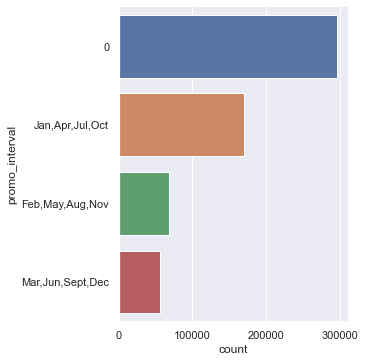

In [46]:
sns.catplot(y="promo_interval", kind="count", orient="h",data=aux2, order=aux2.promo_interval.value_counts().index)

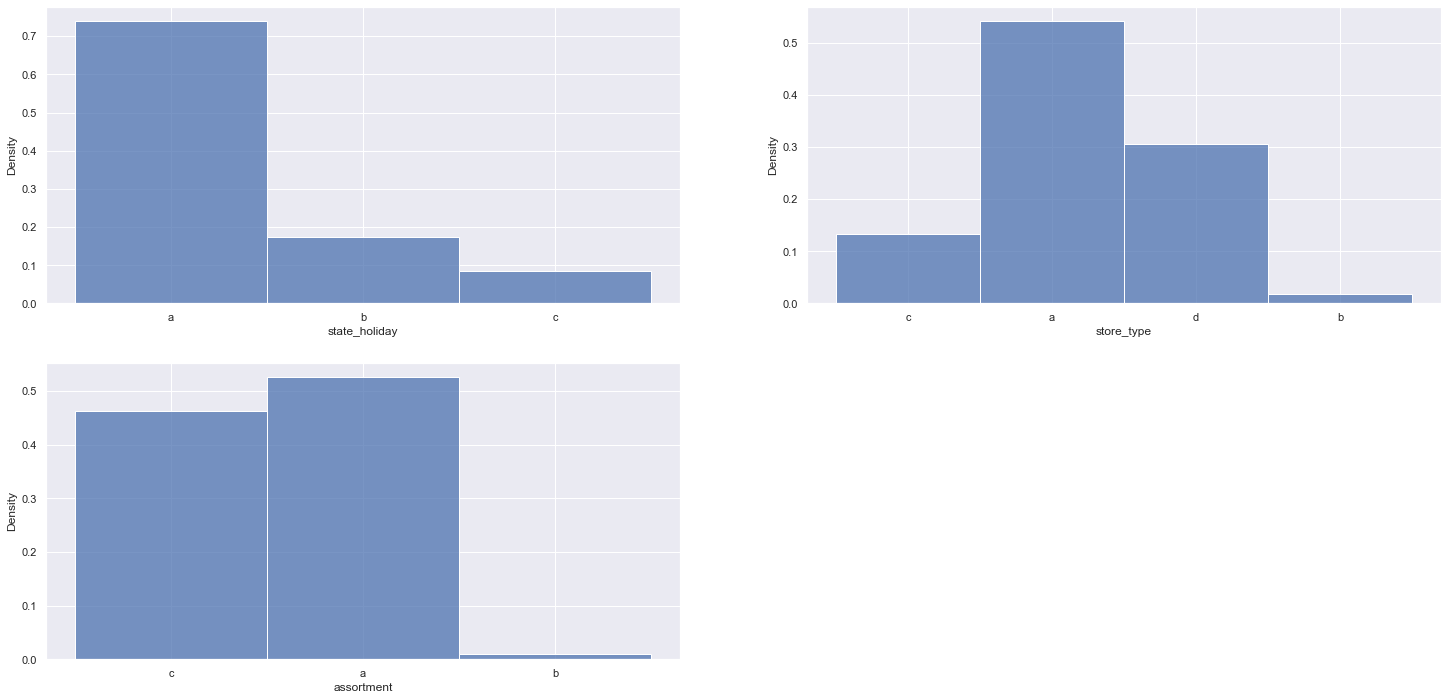

In [47]:
plt.subplot(2, 2, 1)
ax = sns.histplot(data=aux1['state_holiday'],stat='density')

plt.subplot(2, 2, 2)
ax = sns.histplot(aux2['store_type'],stat='density')

plt.subplot(2, 2, 3)
ax = sns.histplot(aux2['assortment'],stat='density')

plt.show()

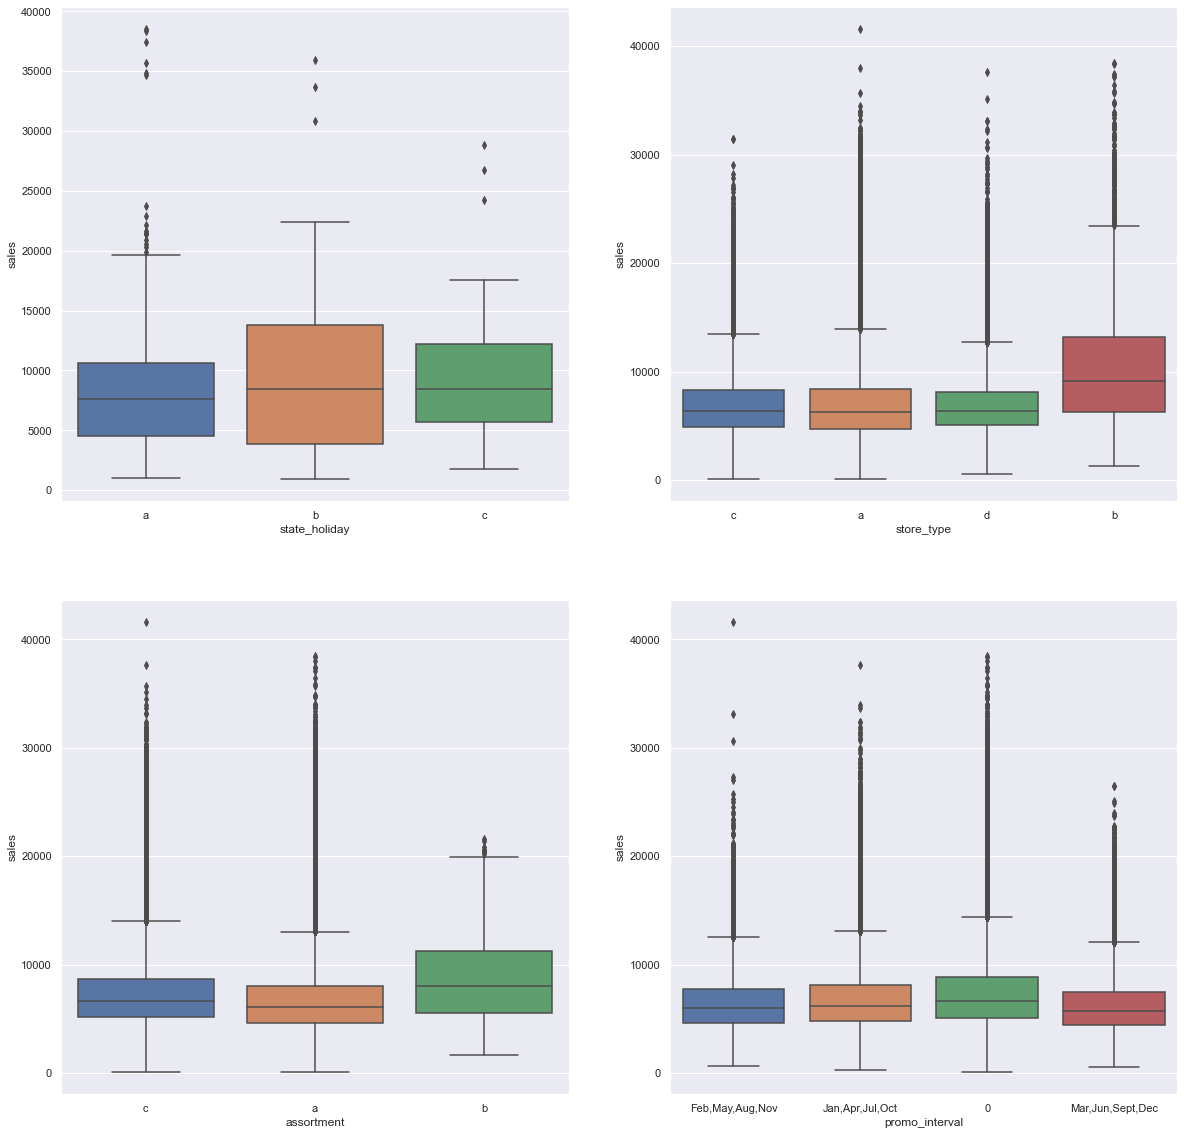

In [48]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(20, 20)

plt.subplot(2, 2, 1)
ax = sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(2, 2, 2)
ax = sns.boxplot(x='store_type', y='sales', data=aux2)

plt.subplot(2, 2, 3)
ax = sns.boxplot(x='assortment', y='sales', data=aux2)

plt.subplot(2, 2, 4)
ax = sns.boxplot(x='promo_interval', y='sales', data=aux2)

# displays plot
plt.show()

#### Conclusions

**State Holiday** - Most sales are NOT made during State Holidays, that's why we filtered to better understand what happens during Holidays. The medium in sales is similar between holidays and sales are usually higher in Holiday B. WE have much more days contemplating Holiday A.<br>
**Store Type** - Store A and D are the one with more records in the database, but their average sales is the same as store C and lower than store B. <br>
**Assortment** - Compared to other assortments, assortment B has much less presence in stores however is the assortment with higher average sales. On the other hand, assortment A and C present many outliers that surpass the maximum sale of assortment B.  <br>
**Promo Interval** - The sales during each Promo Interval is very similar and stores without the promotion seem to sell more <br>

# 2. Feature Engineering

In [49]:
df2 = df1.copy()

## 2.1 Hypothesis

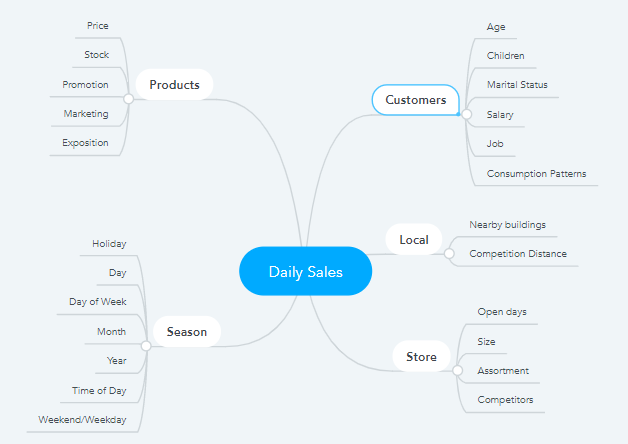

In [4]:
from IPython.display import Image

Image(filename='../image/hyp.PNG')

1. Stores with Extra assortment have higher average sales amount
2. Stores with nearer competitors have less sales amount
3. Stores with oldest competition have higher average sales amount
4. Stores sell, on average, more on holidays
5. As years go by, stores sell more, both on average and total sales amount
6. Stores have higher average sales on the second semester of the year 
7. Stores have higher average and total sales on days of weekends
8. Stores have less sales amount during school holidays
9. Stores sell, on average, more when they have Promo active
10. Stores sell more when Promo 2 starts in Jan
11. Stores sell more after adhering Promo 2 -
12. Stores sell more after adhering Promo 2
12. Stores sell more in the first month of Promo 2

## 2.2 Feature Engineering

### Identifying if sale happened in the first month of Promo 2

In [50]:
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['date_x'].dt.month.map(month_map)

df2['promo2_first_month'] = df2[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


### Date feature creation

In [51]:
#year
df2[ 'year' ] = df2[ 'date_x' ].dt.year

# month
df2[ 'month' ] = df2[ 'date_x' ].dt.month

# day
df2[ 'day' ] = df2[ 'date_x' ].dt.day

# week of year
df2[ 'week_of_year' ] = df2[ 'date_x' ].dt.weekofyear

# year week
df2[ 'year_week' ] = df2[ 'date_x' ].dt.strftime( '%Y-%W' )

# competition since
df2[ 'competition_since' ] = df2.apply( lambda x: datetime.datetime( year=x[ 'competition_open_since_year' ], month = x[ 'competition_open_since_month' ], day = 1 ), axis = 1 )

# competition time month
df2[ 'competition_time_month' ] = (( df2[ 'date_x' ] - df2[ 'competition_since' ] )/30 ).apply( lambda x: x.days ).astype( int )


### Replace categorical values to better understanding

In [52]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3. Filter Variables

In [53]:
df3 = df2.copy()

## 3.1 Row Filtering

### 3.1.1 Filtering closed stores or without sales

In [54]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.1.2 Filtering competitions older than 1980

In [55]:
df3 = df3[(df3['competition_open_since_year'] > 1980)]

## 3.2 Column Filtering

### 3.1.2 Filtering columns we don't have access when running the model and auxiliary columns

In [56]:
# drops the columns
cols_drop = ['customers', 'open', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

# 4. Exploratory Data Analysis

In [57]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Target Variable

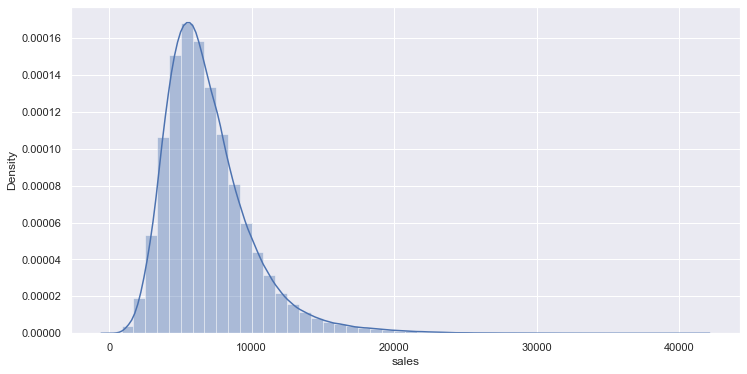

In [58]:
# plots distribution
ax = sns.distplot(df4['sales'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# displays plot
plt.show()

Even removing records without sales, the distribution continued moderately skewed and with a positive kurtosis. There are some possible outliers in our dataset. 
Thee distribution does not follow a normal distribution.

We will perform a variable transformation to try to achieve a normal distribution.

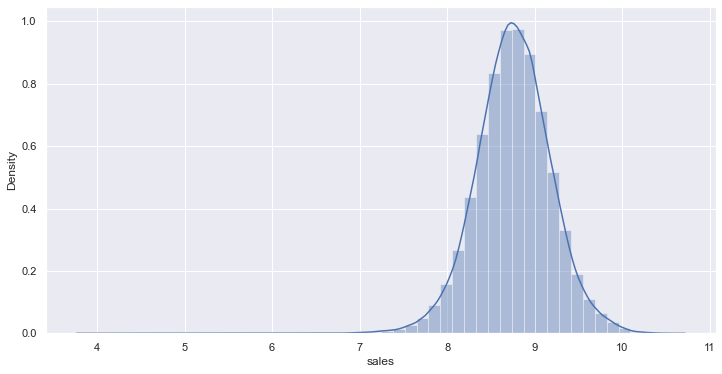

In [59]:
# distribution plotting for 'sales'
# applies log(x + 1) to 'sales'
ax = sns.distplot(np.log1p(df4['sales']))

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

### 4.1.2 Numerical Variables

In [60]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df4, title='Profiling Booking' )
profile.to_file( output_file='insights_report.html' )

### 4.1.3 Categorical Variables

In [61]:
df4['state_holiday'].value_counts()

regular_day       842027
public_holiday    694   
easter_holiday    145   
christmas         71    
Name: state_holiday, dtype: int64

In [62]:
df4['store_type'].value_counts()

a    456420
d    257989
c    112968
b    15560 
Name: store_type, dtype: int64

In [63]:
df4['assortment'].value_counts()

basic       444253
extended    390475
extra       8209  
Name: assortment, dtype: int64

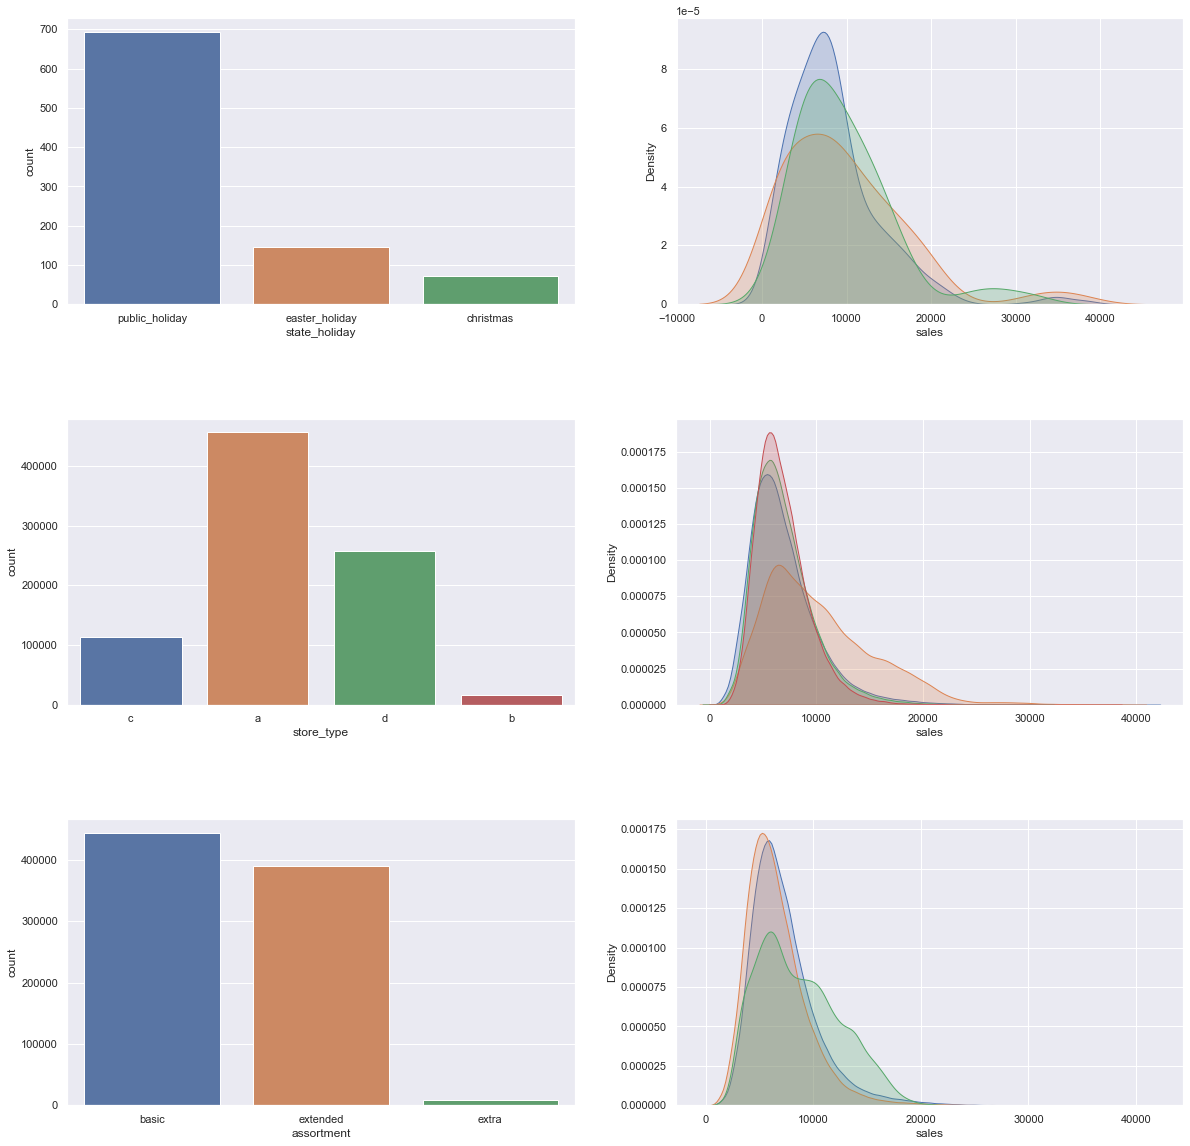

In [64]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(20, 20)

# state_holiday
plt.subplot(3,2,1)
df_no_regular_day = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(df_no_regular_day['state_holiday'])#,order=train_set_4.state_holiday.value_counts().index)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

df4
# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])#,order=train_set_4.store_type.value_counts().index)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])#,order=train_set_4.assortment.value_counts().index)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# display plots
plt.show()

Concerning to the Categorical Variables, we can see that:

- When comparing holidays, we have a similar peak of total sales. In Easter, the peak is lower but sales have the tendency to achieve higher values.

- Store types b, c and d have the same peak of total sales. Store type achieves much higher sales amounts.

- Stores with Extra assortment, even with lowest number of stores, achieves higher sales amounts.


## 4.2 Bivariate Analysis - Hypothesis

1. Stores with Extra assortment have higher average sales amount
2. Stores with nearer competitors have less sales amount
3. Stores with oldest competition have higher average sales amount
4. Stores sell, on average, more on holidays
5. As years go by, stores sell more, both on average and total sales amount
6. Stores have higher average sales on the second semester of the year 
7. Stores have higher average and total sales on days of weekends
8. Stores have less sales amount during school holidays
9. Stores sell, on average, more when they have Promo active
10. Stores sell more when Promo 2 starts in Jan
11. Stores sell more after adhering Promo 2 -
12. Stores sell more after adhering Promo 2
12. Stores sell more in the first month of Promo 2

### 1. Stores with Extra assortment have higher average sales amount: TRUE

In [65]:
df_total_sales_by_assortment = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
df_total_sales_by_assortment
# If we consider the sum, we can have biased conclusions as there are much less 
#Extra assortment stores than Basic and Extended
#basic       310891
#extended    273442
#extra       5758

,assortment,sales
0,basic,2940527859
1,extended,2850398046
2,extra,70946312


In [66]:
df_total_sales_by_assortment = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
df_total_sales_by_assortment

,assortment,sales
0,basic,"6,619.038834"
1,extended,"7,299.822129"
2,extra,"8,642.503594"


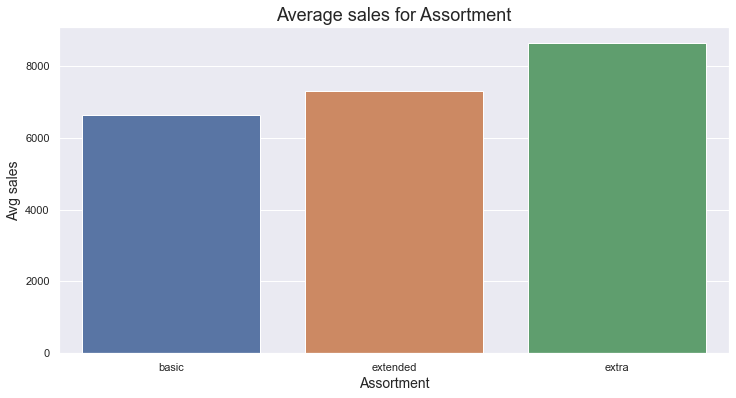

In [67]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

ax = sns.barplot(x='assortment', y='sales', data=df_total_sales_by_assortment)

# sets the title and axis labels
set_plots_features(ax, "Average sales for Assortment", "Assortment", "Avg sales")

# displays the plot
plt.show()

We can evaluate the evolution of each Assortment every year:

In [68]:
# checks each assortment sales 
df_total_sales_by_year_week_assortment = df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).mean().reset_index()
df_total_sales_pivot = df_total_sales_by_year_week_assortment.pivot(index='year_week', columns='assortment', values='sales')
df_total_sales_pivot

assortment,basic,extended,extra
year_week,,,
2013-00,"5,637.483382","6,093.742506","5,282.431373"
2013-01,"7,302.238672","7,553.174373","6,254.982143"
2013-02,"5,046.022798","5,283.595773","6,286.783333"
2013-03,"6,848.999437","6,983.169960","6,423.206349"
2013-04,"5,607.853926","5,944.899146","6,483.232143"
...,...,...,...
2015-26,"7,807.672191","8,786.363371","10,860.000000"
2015-27,"5,710.510256","6,623.299903","9,302.158730"
2015-28,"7,239.031259","8,298.096690","10,032.015873"


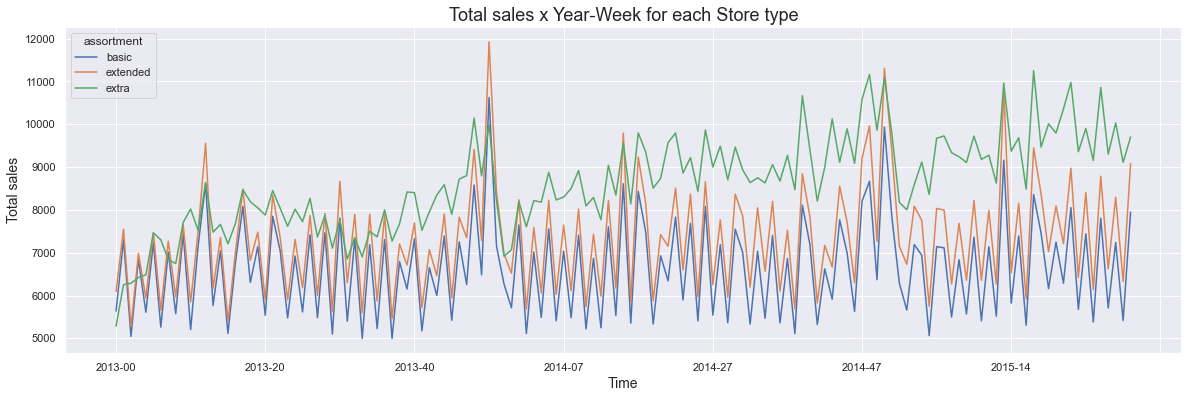

In [69]:
ax = df_total_sales_pivot.plot()

# sets the figure size in inches
ax.figure.set_size_inches(20, 6)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Year-Week for each Store type", "Time", "Total sales")

# displays the plot
plt.show()

### 2. Stores with nearer competitors have less sales amount: PARCIAL FALSE

When looking only for the average sales of binned groups there is no clear relationship between competition distance and sales. However, when we plot average sales without the bins, we can see peaks of sales are concentrate in stores where competition is near, specially under 20000m.

To facilite analysis, we will create bins with the competition distance

In [70]:
# creates bins that range from 0 to 20000 with steps of 1000
bins = list (np.arange(0, 20000, 1000))

df_total_sales_by_competition_distance = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
df_total_sales_by_competition_distance['competition_distance_binned'] = pd.cut(df_total_sales_by_competition_distance['competition_distance'], bins=bins)
df_competition_distance_binned = df_total_sales_by_competition_distance[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
df_competition_distance_binned

,competition_distance_binned,sales
0,"(0, 1000]","7,049.162124"
1,"(1000, 2000]","7,119.433437"
2,"(2000, 3000]","6,655.004184"
3,"(3000, 4000]","6,454.243979"
4,"(4000, 5000]","7,174.252831"
5,"(5000, 6000]","6,555.523621"
6,"(6000, 7000]","6,404.327526"
7,"(7000, 8000]","7,050.580700"
8,"(8000, 9000]","6,996.111601"
9,"(9000, 10000]","6,594.781982"


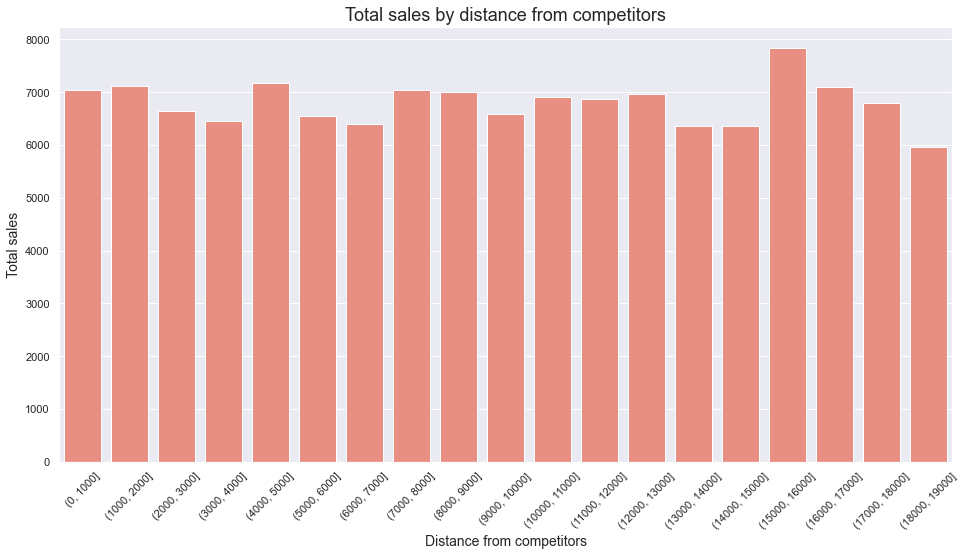

In [71]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
ax = sns.barplot(x='competition_distance_binned', y='sales', data=df_competition_distance_binned, color="salmon")

# rotates xlabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# sets the title and axis labels
set_plots_features(ax, "Total sales by distance from competitors", "Distance from competitors", "Total sales")

# displays the plot
plt.show()

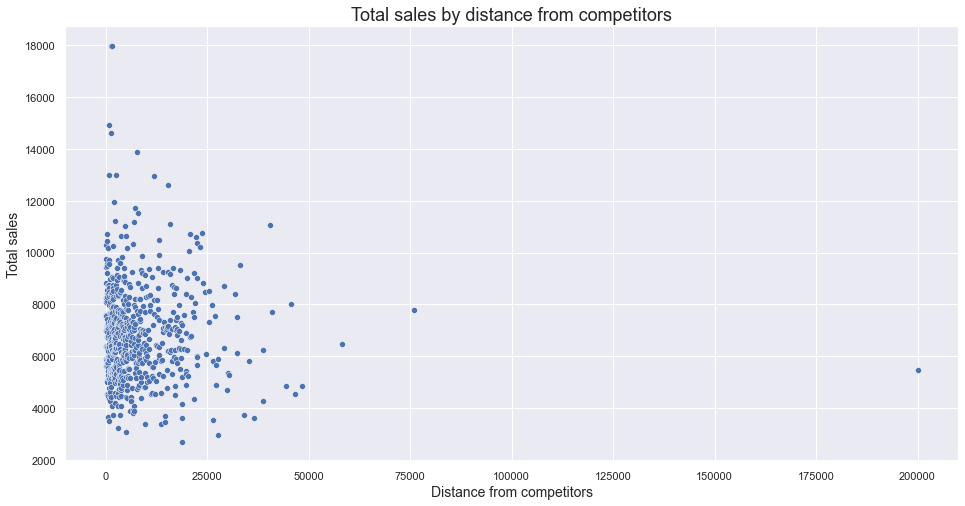

In [72]:
# checks total sales for each 'competition_distance'
df_total_sales_by_competition_distance = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot for sales in relation to competition_distance
ax = sns.scatterplot(x='competition_distance', y='sales', data=df_total_sales_by_competition_distance)

# sets the title and axis labels
set_plots_features(ax, "Total sales by distance from competitors", "Distance from competitors", "Total sales")

# displays the plot
plt.show()

### 3. Stores with oldest competition have higher average sales amount: FALSE

When considering average sales, when the competitor opened has little impact

In [73]:
# gets all sales by months since the a competition store opened
df_total_sales_by_comp_time_month = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
# gets only the 120 months AND opened in the same month of the sale
df_total_sales_120_months = df_total_sales_by_comp_time_month[(df_total_sales_by_comp_time_month['competition_time_month'] < 120) & (df_total_sales_by_comp_time_month['competition_time_month'] != 0)]
df_total_sales_120_months

,competition_time_month,sales
0,-32,"6,606.666667"
1,-31,"6,759.612245"
2,-30,"6,912.337461"
3,-29,"7,136.689888"
4,-28,"7,011.006745"
...,...,...
147,115,"6,851.367615"
148,116,"6,756.894264"
149,117,"6,843.752185"
150,118,"6,986.997579"


Negative values: We know when a competitor store will still open in x months. <br>
Positive values: Competitor store was already opened when we opened the stire.

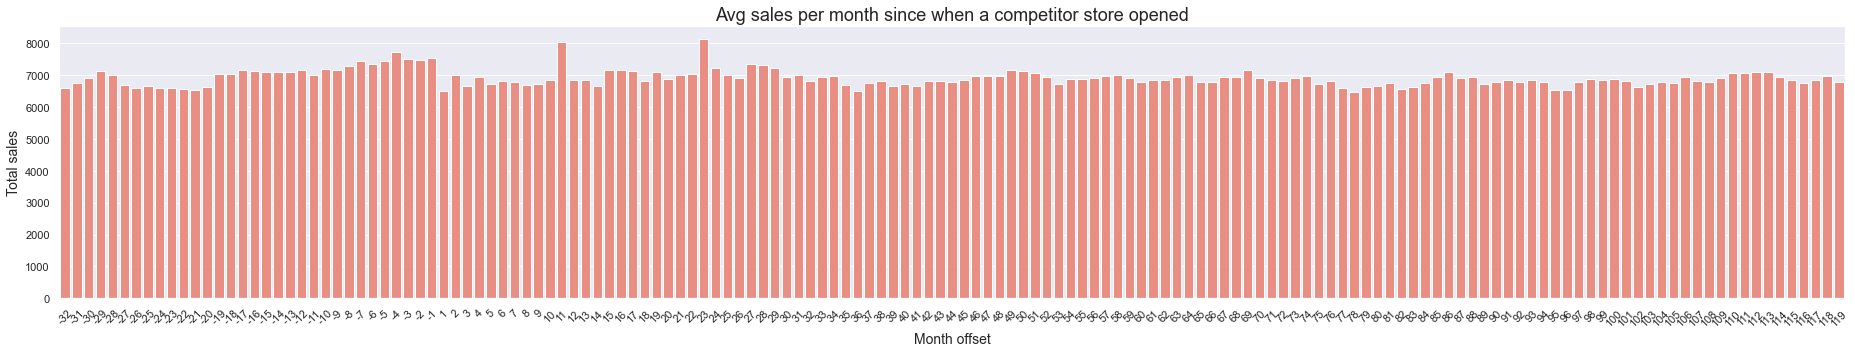

In [74]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(32, 5)

# plots a barplot
ax = sns.barplot(x='competition_time_month', y='sales', data=df_total_sales_120_months, color='salmon')

# rotates the xticks
plt.xticks(rotation=90)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# sets the title and axis labels
set_plots_features(ax, "Avg sales per month since when a competitor store opened", "Month offset", "Total sales")

# displays plot
plt.show()

### 4. Stores sell, on average, more on holidays: TRUE

The average sales during public holidays is higher, but every year we have diffent holidays as the one with highest average sales

In [75]:
# getting the total sales by state holiday
df_total_sales_by_state_holiday = df4[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
df_total_sales_by_state_holiday

,state_holiday,sales
0,christmas,"9,743.746479"
1,easter_holiday,"9,887.889655"
2,public_holiday,"8,487.471182"
3,regular_day,"6,952.100541"


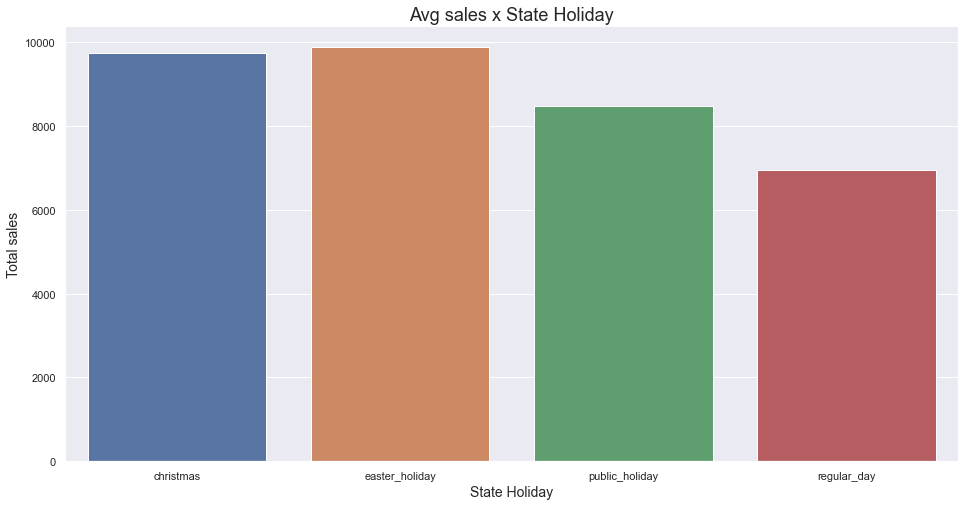

In [76]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by state holiday
sns.barplot(x='state_holiday', y='sales', data=df_total_sales_by_state_holiday)

# sets the title and axis labels
set_plots_features(ax, "Avg sales x State Holiday", "State Holiday", "Total sales")

# displays the plot
plt.show()

In [77]:
# gets total sales by year by state holiday
df_total_sales_by_year_by_sate_holiday = df4[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).mean().reset_index()
df_total_sales_by_year_by_sate_holiday

,year,state_holiday,sales
0,2013,christmas,"9,199.500000"
1,2013,easter_holiday,"9,680.787234"
2,2013,public_holiday,"7,863.632184"
3,2013,regular_day,"6,810.572496"
4,2014,christmas,"10,303.542857"
5,2014,easter_holiday,"9,456.183673"
6,2014,public_holiday,"8,685.900000"
7,2014,regular_day,"7,022.322865"
8,2015,easter_holiday,"10,518.244898"
9,2015,public_holiday,"9,084.357513"


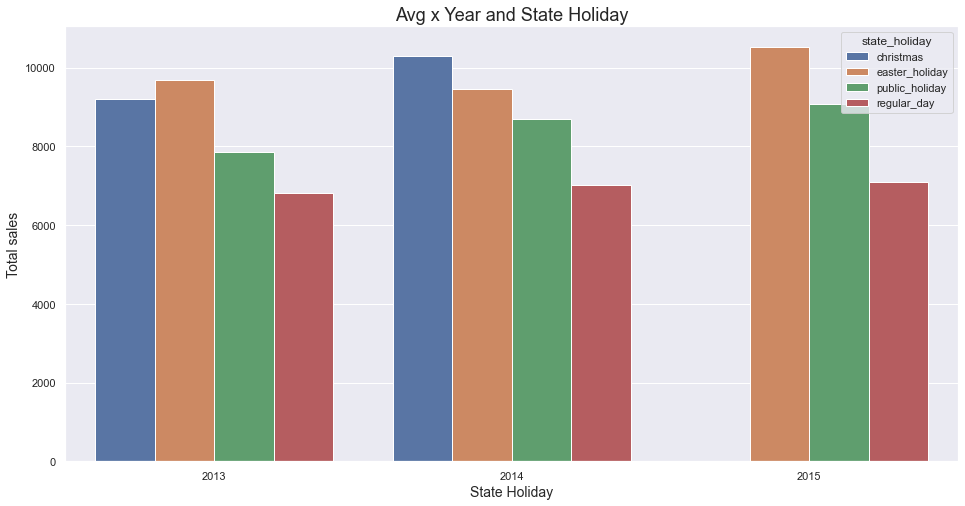

In [78]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by state holiday
sns.barplot(x='year', y='sales', hue='state_holiday', data=df_total_sales_by_year_by_sate_holiday)

# sets the title and axis labels
set_plots_features(ax, "Avg x Year and State Holiday", "State Holiday", "Total sales")

# displays the plot
plt.show()

### 5. As years go by, stores sell more, both on average and total sales amount: FALSE - see note

We must have in mind that the year 2015 isn't finished yet. When considering average sales, the trend is to have an increasing yearly average sales. But this trend isn't true when considering total sales.

In [79]:
df_total_sales_by_year_mean = df4[['year', 'sales']].groupby('year').mean().reset_index()
df_total_sales_by_year_total = df4[['year', 'sales']].groupby('year').sum().reset_index()

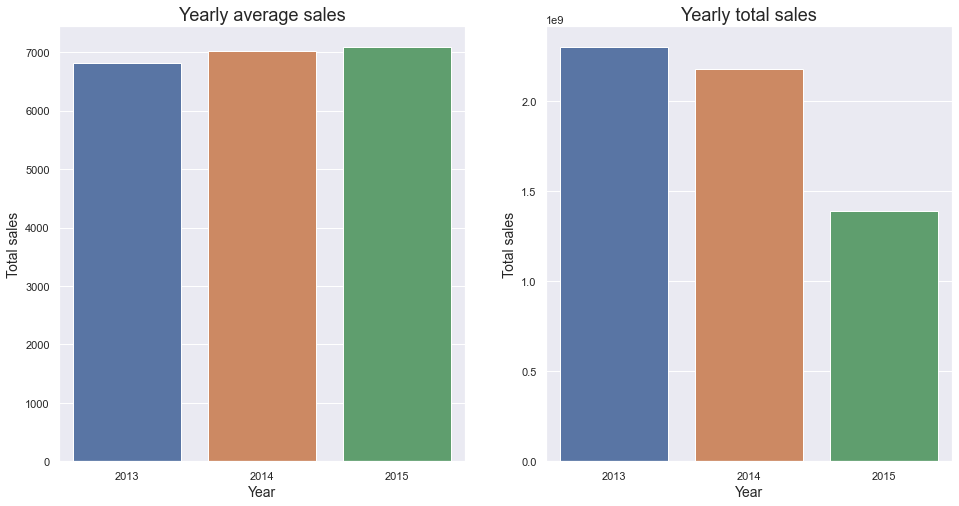

In [80]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by year
plt.subplot(1, 2, 1)
ax = sns.barplot(x='year', y='sales', data=df_total_sales_by_year_mean)

# sets the title and axis labels
set_plots_features(ax, "Yearly average sales", "Year", "Total sales")

plt.subplot(1, 2, 2)
ax = sns.barplot(x='year', y='sales', data=df_total_sales_by_year_total)

# sets the title and axis labels
set_plots_features(ax, "Yearly total sales", "Year", "Total sales")

### 6. Stores have higher average sales on the second semester of the year - considering only 2013 and 2014: TRUE

In [81]:
# gets the total sales by month
total_sales_by_month= df4[df4['year']<2015]
df_total_sales_by_month = total_sales_by_month[['month', 'sales']].groupby('month').mean().reset_index()
df_total_sales_by_month

,month,sales
0,1,"6,387.273243"
1,2,"6,551.338666"
2,3,"6,925.342026"
3,4,"6,894.832843"
4,5,"7,008.682969"
5,6,"6,845.147969"
6,7,"6,908.160414"
7,8,"6,647.530056"
8,9,"6,545.620672"
9,10,"6,600.752880"


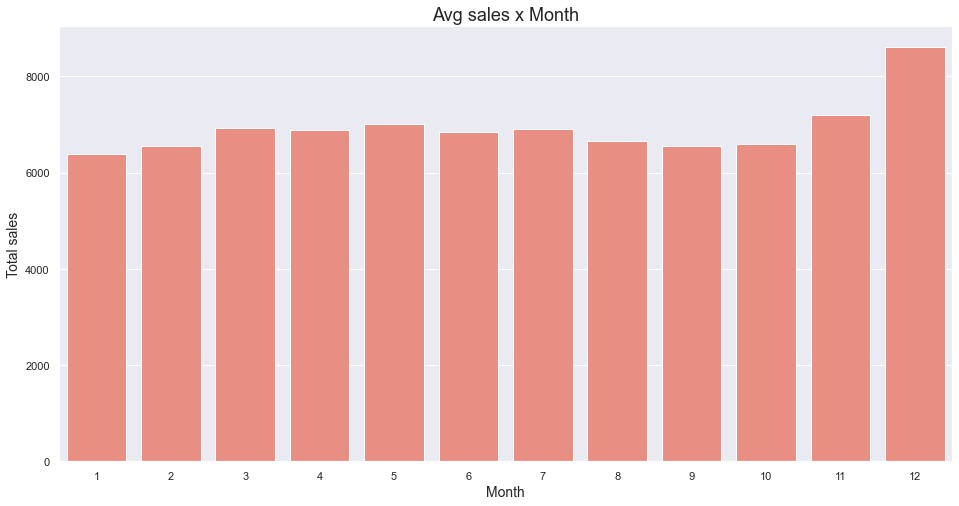

In [82]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by month
ax = sns.barplot(x='month', y='sales', data=df_total_sales_by_month, color='salmon')

# sets the title and axis labels
set_plots_features(ax, "Avg sales x Month", "Month", "Total sales")

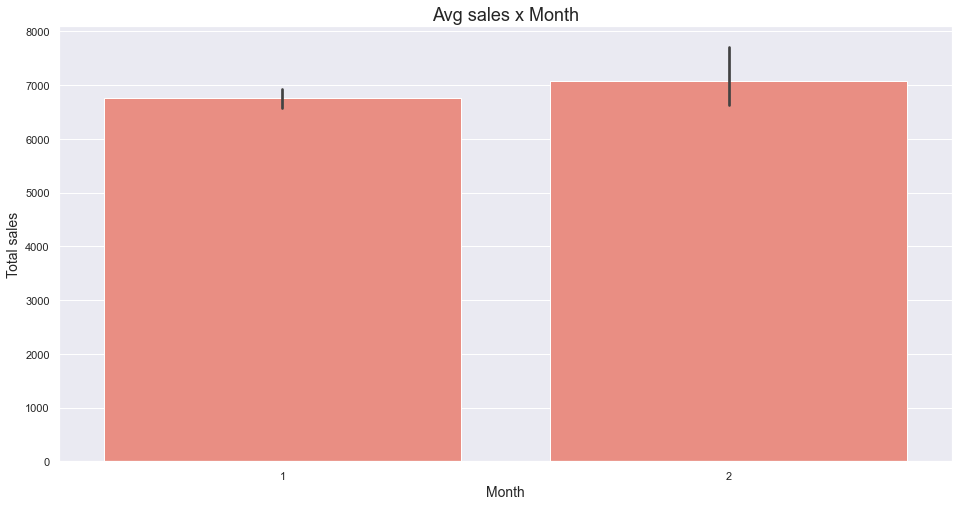

In [83]:
df_total_sales_by_month['sem'] = df_total_sales_by_month['month'].apply(lambda x: 1 if x < 7 else 2)
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by month
ax = sns.barplot(x='sem', y='sales', data=df_total_sales_by_month, color='salmon')

# sets the title and axis labels
set_plots_features(ax, "Avg sales x Month", "Month", "Total sales")

In [84]:
df_total_sales_by_month

,month,sales,sem
0,1,"6,387.273243",1
1,2,"6,551.338666",1
2,3,"6,925.342026",1
3,4,"6,894.832843",1
4,5,"7,008.682969",1
5,6,"6,845.147969",1
6,7,"6,908.160414",2
7,8,"6,647.530056",2
8,9,"6,545.620672",2
9,10,"6,600.752880",2


### 7. Stores have higher average and total sales on days of weekends: FALSE

On Saturday, evaluating both average and total sales, it is the day of week with less sales. The average sales on Sundays are quite high, but when it comes to total sales, it is much smaller to all other days.

In [85]:
df_total_sales_by_day_of_week_total = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
df_total_sales_by_day_of_week_avg = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

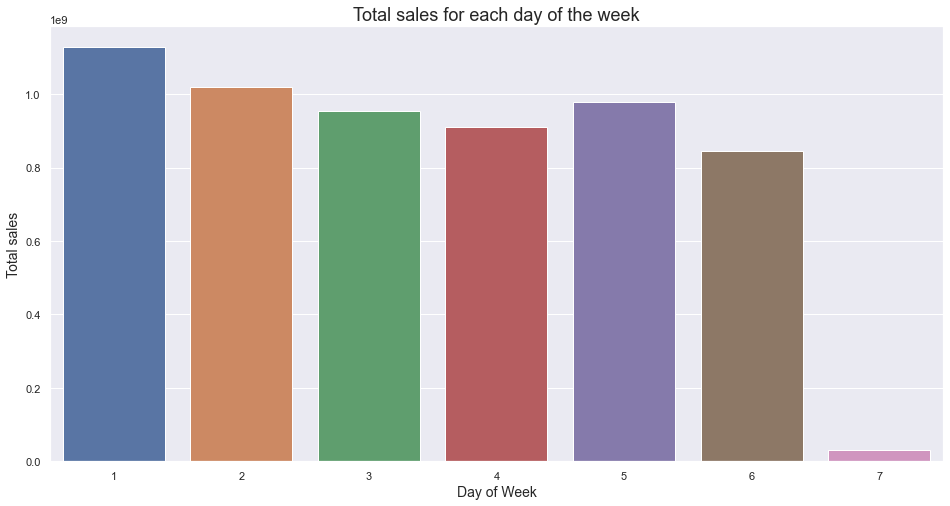

In [86]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by day_of_week
ax = sns.barplot(x='day_of_week', y='sales', data=df_total_sales_by_day_of_week_total)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")

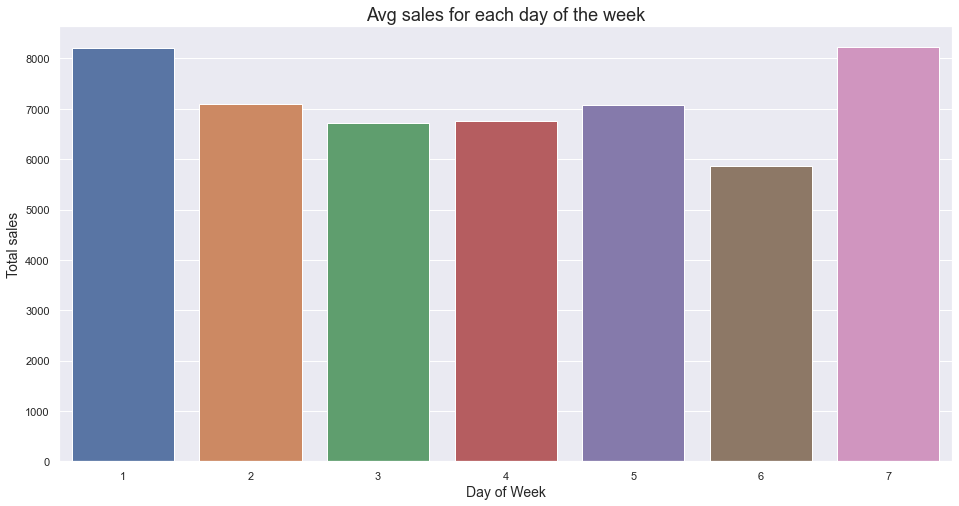

In [87]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by day_of_week
ax = sns.barplot(x='day_of_week', y='sales', data=df_total_sales_by_day_of_week_avg)

# sets the title and axis labels
set_plots_features(ax, "Avg sales for each day of the week", "Day of Week", "Total sales")

### 8. Stores have less sales amount during school holidays: TRUE - see note

The gap of days not in school holidays is higher than during school holidays, therefore, makes sense that the total amount of sales during school holidays is smaller. However, when evaluating average sales, sales during school holidays are slighly higher.

In [88]:
df_total_sales_by_school_holiday_total = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
df_total_sales_by_school_holiday_avg = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

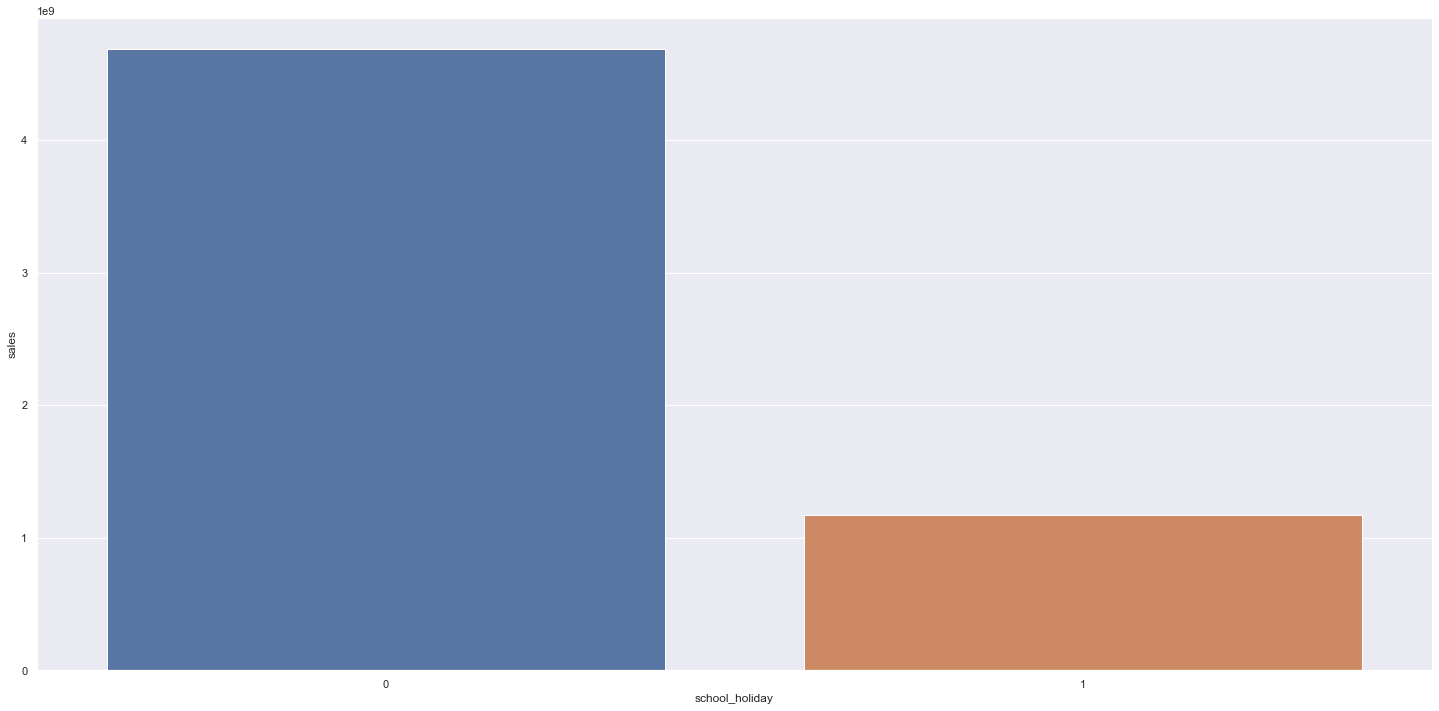

In [89]:
ax = sns.barplot(x='school_holiday', y='sales', data=df_total_sales_by_school_holiday_total)
plt.show()

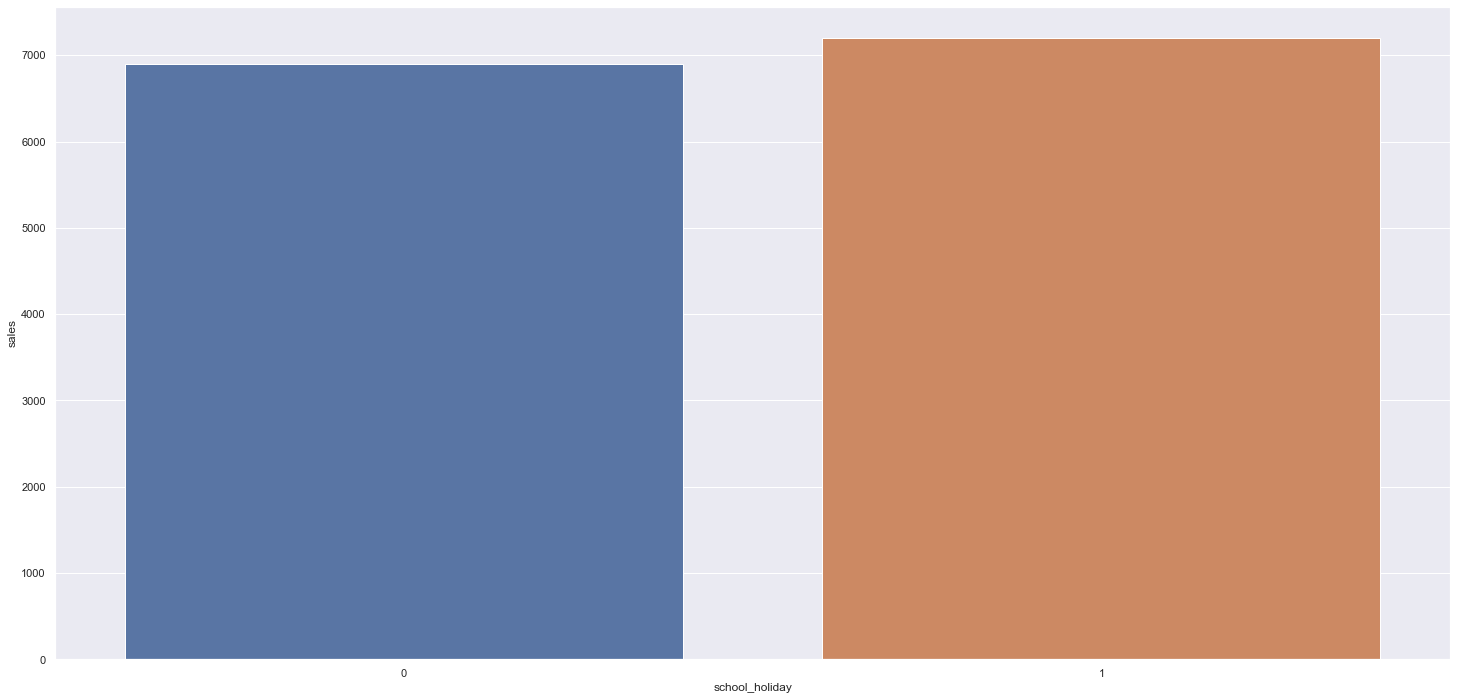

In [90]:
ax = sns.barplot(x='school_holiday', y='sales', data=df_total_sales_by_school_holiday_avg)
plt.show()

### 9. Stores sell, on average, more when they have Promo active: TRUE

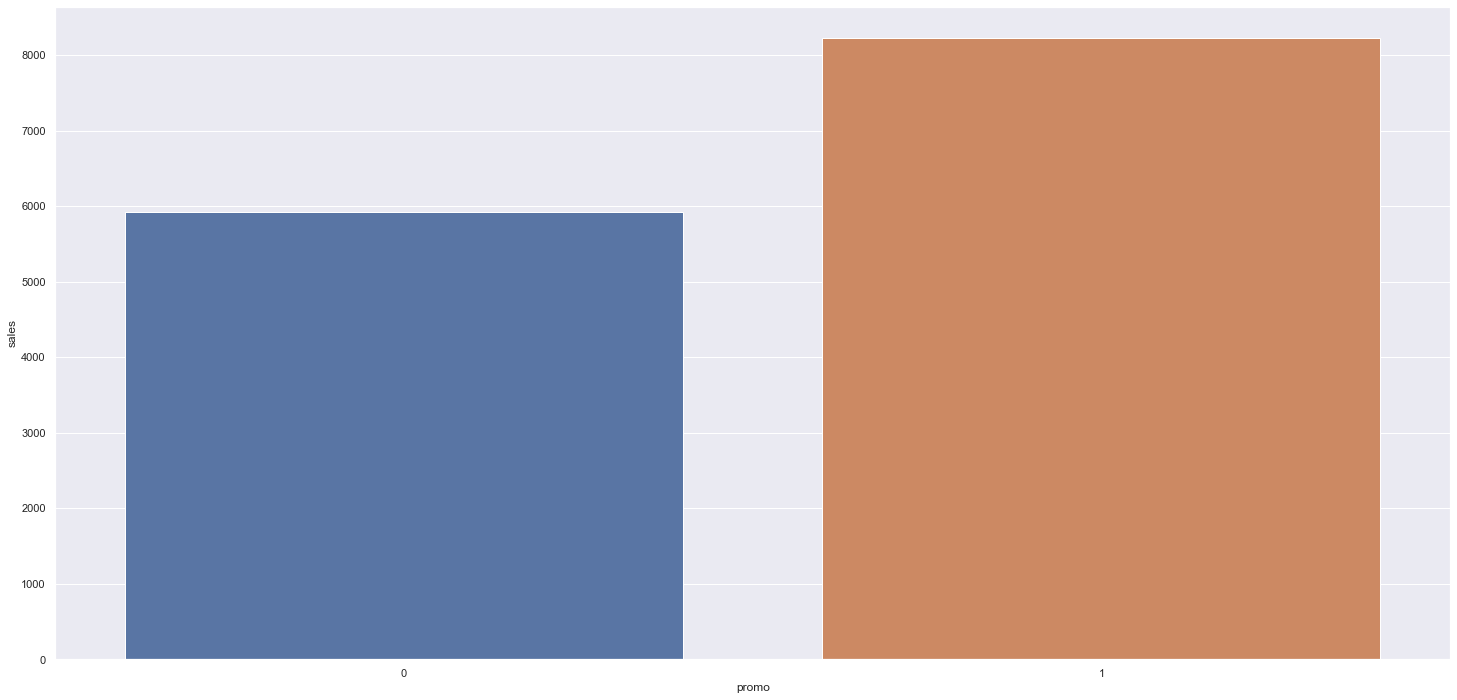

In [91]:
df_avg_sales_by_promo = df4[['promo', 'sales']].groupby('promo').mean().reset_index()
ax = sns.barplot(x='promo', y='sales', data=df_avg_sales_by_promo)
plt.show()

### 10. Stores sell more when Promo 2 starts in Jan: TRUE - see note

When considering only stores that participate of Promo 2, the average sales of stores taht starts Promo 2 in Jan is slightly higher. When adding stores that do not adhere to Promo 2, the average sales of those stores is higher.

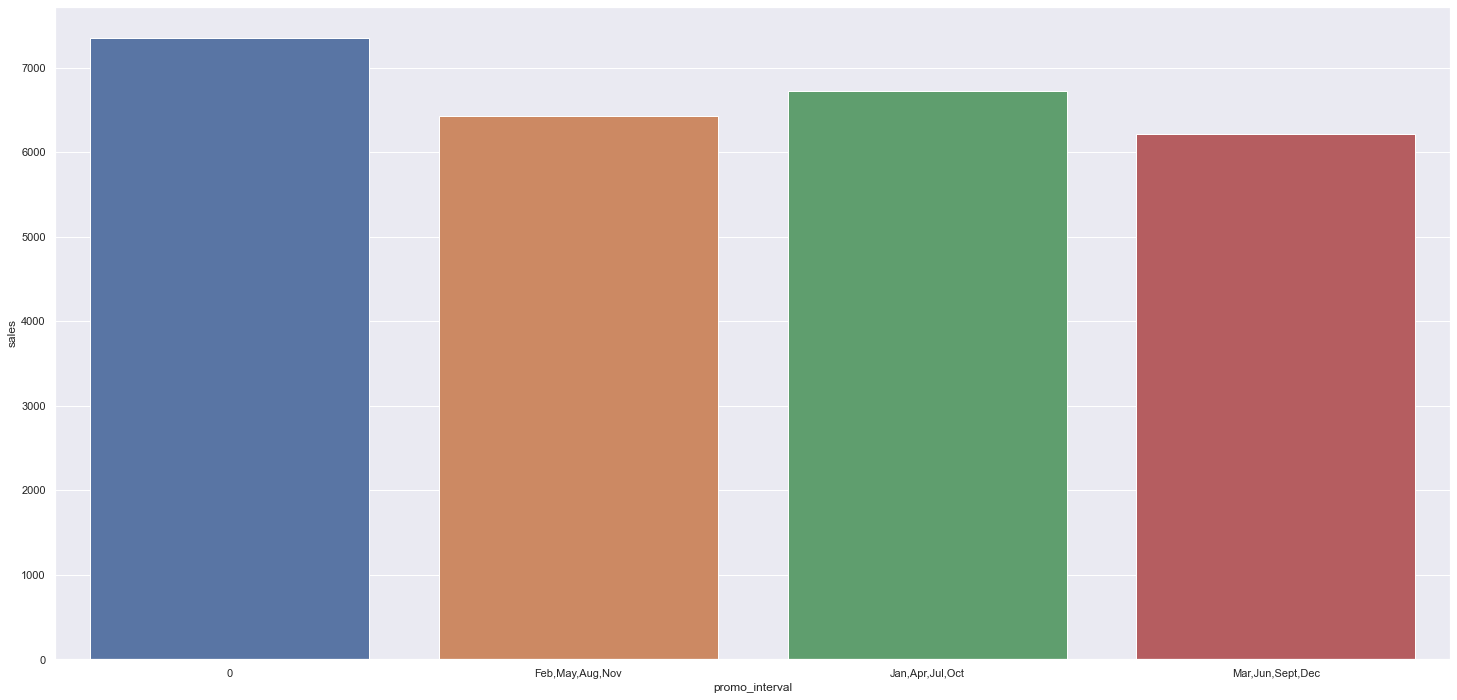

In [92]:
df_avg_sales_by_promo = df4[['promo_interval', 'sales']].groupby('promo_interval').mean().reset_index()
ax = sns.barplot(x='promo_interval', y='sales', data=df_avg_sales_by_promo)
plt.show()

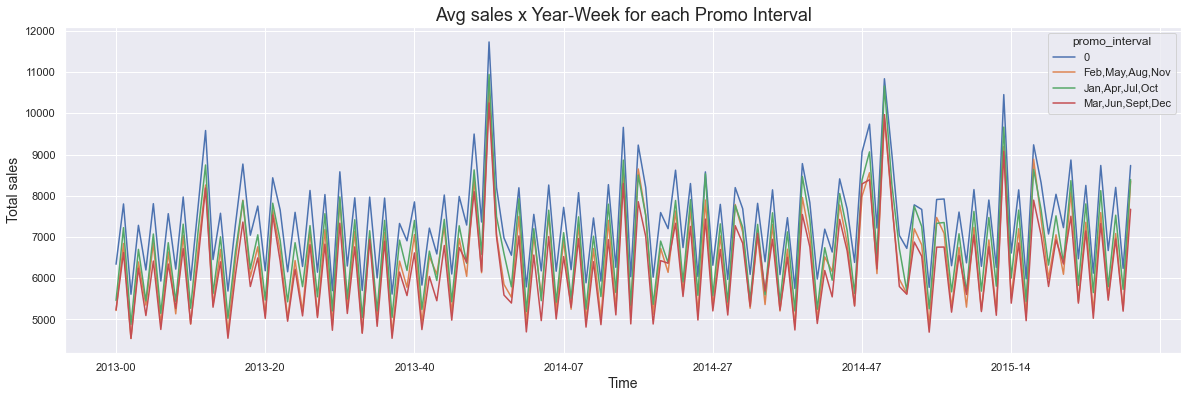

In [93]:
# checks each assortment sales 
df_total_sales_by_promo2 = df4[['year_week', 'promo_interval','sales']].groupby(['year_week','promo_interval']).mean().reset_index()
df_total_sales_pivot = df_total_sales_by_promo2.pivot(index='year_week', columns='promo_interval', values='sales')
df_total_sales_pivot

ax = df_total_sales_pivot.plot()

# sets the figure size in inches
ax.figure.set_size_inches(20, 6)

# sets the title and axis labels
set_plots_features(ax, "Avg sales x Year-Week for each Promo Interval", "Time", "Total sales")

# displays the plot
plt.show()

### 11. Stores sell more after adhering Promo 2 - see note

Unfortunetelly there's not enough data to evaluate this hypothesis.WE only have data on sales from 2013 to mid 2015. When analysing sales of stores that adhere promo 2 from year 2013, we can see a slightly increase in average sales.

In [94]:
df4.promo2_since_year.value_counts()

0       423292
2011    95035 
2013    91854 
2014    65135 
2012    59933 
2009    53824 
2010    46412 
2015    7452  
Name: promo2_since_year, dtype: int64

In [95]:
year_2012 = df4[df4['promo2_since_year']== 2012]
year_2013 = df4[df4['promo2_since_year']== 2013]
year_2014 = df4[df4['promo2_since_year']== 2014]
year_2015 = df4[df4['promo2_since_year']== 2015]

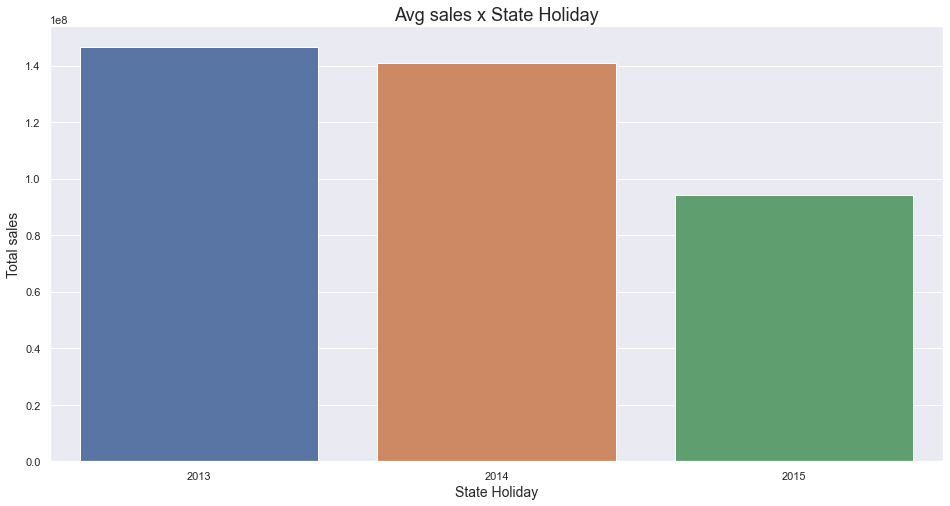

In [96]:
# checks each assortment sales 
df_total_sales_year_2009 = year_2012[['year','sales']].groupby(['year']).sum().reset_index()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by state holiday
sns.barplot(x='year', y='sales', data=df_total_sales_year_2009)

# sets the title and axis labels
set_plots_features(ax, "Avg sales x State Holiday", "State Holiday", "Total sales")

# displays the plot
plt.show()

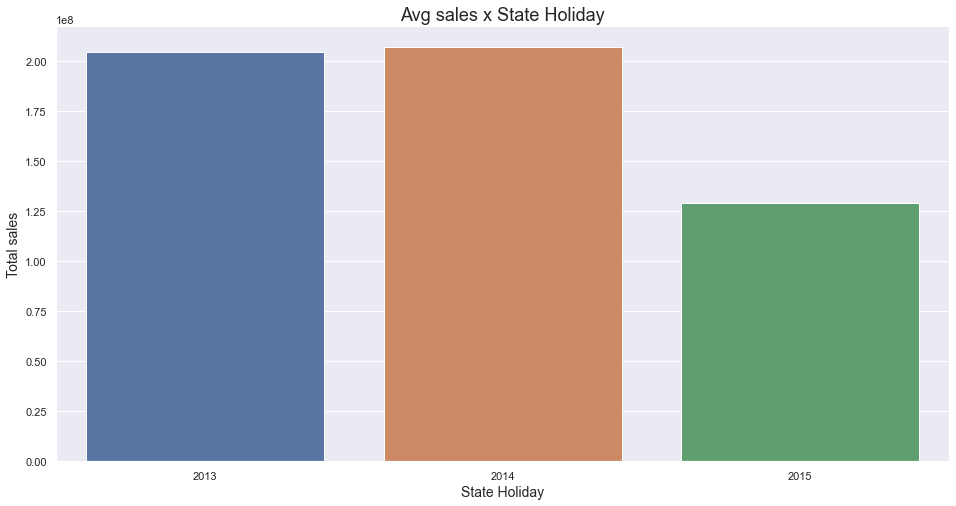

In [97]:
# checks each assortment sales 
df_total_sales_year_2009 = year_2013[['year','sales']].groupby(['year']).sum().reset_index()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by state holiday
sns.barplot(x='year', y='sales', data=df_total_sales_year_2009)

# sets the title and axis labels
set_plots_features(ax, "Avg sales x State Holiday", "State Holiday", "Total sales")

# displays the plot
plt.show()

### 12. Stores sell more in the first month of Promo 2: FALSE

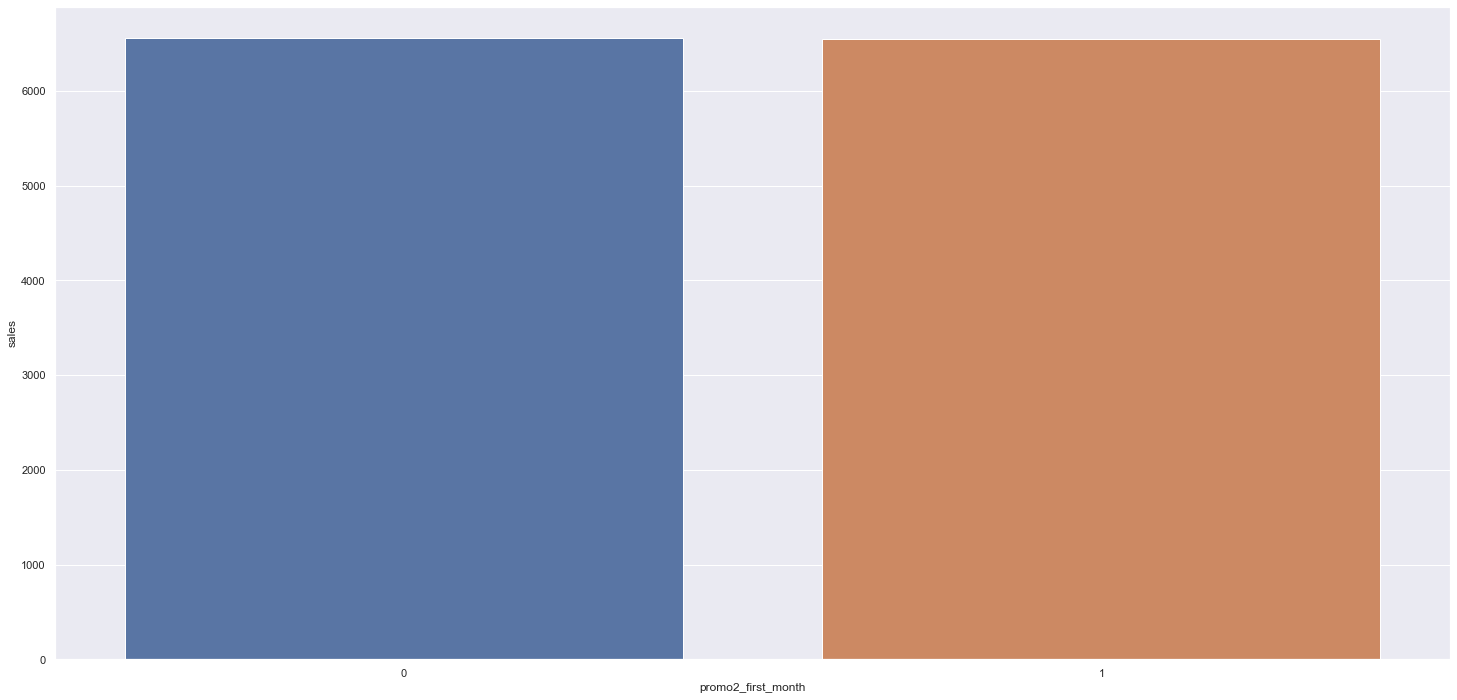

In [98]:
promo_month=df4[df4['promo2']==1]
df_avg_sales_by_promo_month = promo_month[['promo2_first_month', 'sales']].groupby('promo2_first_month').mean().reset_index()
ax = sns.barplot(x='promo2_first_month', y='sales', data=df_avg_sales_by_promo_month)
plt.show()

###  Hypotheses summary

In [99]:
tab = [
    ['Hypothesis','Conclusion','Relavance to ML model'],
    ['H1','True','High'],
    ['H2','False','Medium'],
    ['H3','False','Medium'],
    ['H4','True','High'],
    ['H5','False','Medium'],
    ['H6','True','High'],
    ['H7','False','High'],
    ['H8','True','High'],
    ['H9','True','High'],
    ['H10','True','Low'],
    ['H11','not used','--'],
    ['H12','False','Low']
]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relavance to ML model
------------  ------------  -----------------------
H1            True          High
H2            False         Medium
H3            False         Medium
H4            True          High
H5            False         Medium
H6            True          High
H7            False         High
H8            True          High
H9            True          High
H10           True          Low
H11           not used      --
H12           False         Low


## 4.3 Multivariate Analysis

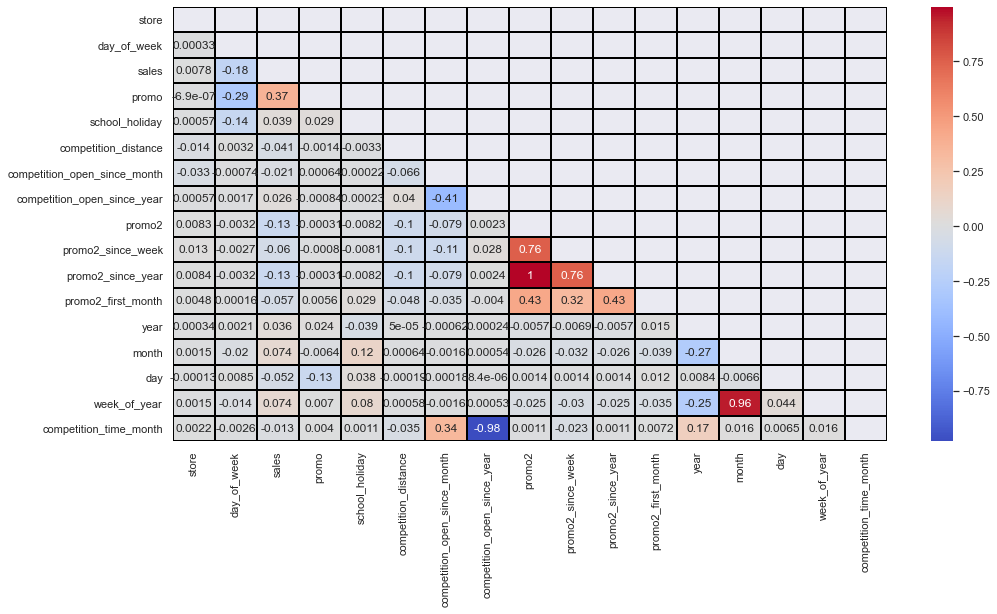

In [100]:
num_attributes = df4.select_dtypes( include = ['int64', 'float64','int32'])
cat_attributes = df4.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]','int32'])

# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
matrix = np.triu(correlation)

sns.heatmap(correlation, annot=True, cmap='coolwarm',linewidths=1, linecolor='black',mask=matrix)

# displays the plot
plt.show()

In [101]:
from scipy import stats
cat_attributes.head().T

,0,1,2,3,4
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
store_type,c,c,c,c,c
assortment,basic,basic,basic,basic,basic
promo_interval,0,0,0,0,0
year_week,2015-30,2015-30,2015-30,2015-30,2015-30


In [102]:
# possible combinations between categorical variables
a1 = cramer_v(cat_attributes['state_holiday'], cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
a3 = cramer_v(cat_attributes['state_holiday'], cat_attributes['assortment'])
a4 = cramer_v(cat_attributes['state_holiday'], cat_attributes['promo_interval'])

a5 = cramer_v(cat_attributes['store_type'], cat_attributes['state_holiday'])
a6 = cramer_v(cat_attributes['store_type'], cat_attributes['store_type'])
a7 = cramer_v(cat_attributes['store_type'], cat_attributes['assortment'])
a8 = cramer_v(cat_attributes['store_type'], cat_attributes['promo_interval'])

a9 = cramer_v(cat_attributes['assortment'], cat_attributes['state_holiday'])
a10 = cramer_v(cat_attributes['assortment'], cat_attributes['store_type'])
a11 = cramer_v(cat_attributes['assortment'], cat_attributes['assortment'])
a12 = cramer_v(cat_attributes['assortment'], cat_attributes['promo_interval'])

a13 = cramer_v(cat_attributes['promo_interval'], cat_attributes['state_holiday'])
a14 = cramer_v(cat_attributes['promo_interval'], cat_attributes['store_type'])
a15 = cramer_v(cat_attributes['promo_interval'], cat_attributes['assortment'])
a16 = cramer_v(cat_attributes['promo_interval'], cat_attributes['promo_interval'])

# builds the dataset to make the correlations
d = pd.DataFrame({'state_holiday': [a1, a2, a3, a4],
                  'store_type': [a5, a6, a7, a8],
                  'assortment': [a9, a10, a11, a12],
                  'promo_interval': [a13, a14, a15, a16]
             })

# sets index equal to columns
d = d.set_index(d.columns)
d
#The range of Cramér V is [0 to 1], so we don't have negative correlation

,state_holiday,store_type,assortment,promo_interval
state_holiday,1.000002,0.071062,0.067543,0.006466
store_type,0.071062,1.000002,0.538127,0.074468
assortment,0.067543,0.538127,1.000001,0.061753
promo_interval,0.006466,0.074468,0.061753,1.000002


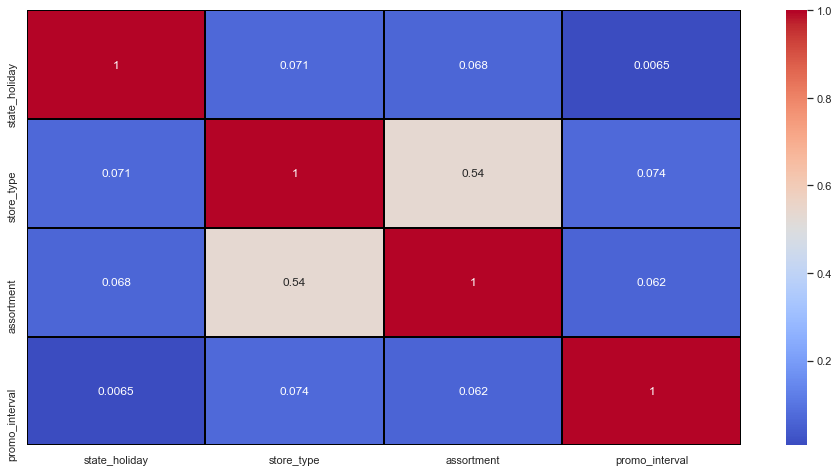

In [103]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(d, annot=True, cmap='coolwarm',linewidths=1, linecolor='black')

# displays plot
plt.show()

In [104]:
#As observed in the results, the correlation coefficient between store_type and assortment is 0.54 which is a medium correlation and makes sense, as the bigger the store, the higher is the assortment of its products.

# 5. Data Preparation

In [105]:
df5 = df4.copy()

In [106]:
df5.dtypes

store                           int64         
day_of_week                     int64         
date_x                          datetime64[ns]
sales                           int64         
promo                           int64         
state_holiday                   object        
school_holiday                  int64         
store_type                      object        
assortment                      object        
competition_distance            float64       
competition_open_since_month    int32         
competition_open_since_year     int32         
promo2                          int64         
promo2_since_week               int32         
promo2_since_year               int32         
promo_interval                  object        
date_y                          datetime64[ns]
promo2_first_month              int64         
year                            int64         
month                           int64         
day                             int64         
week_of_year 

## 5.1 Normalization

Not used

## 5.2 Rescaling

In [107]:
rs = RobustScaler()
mms = MinMaxScaler()

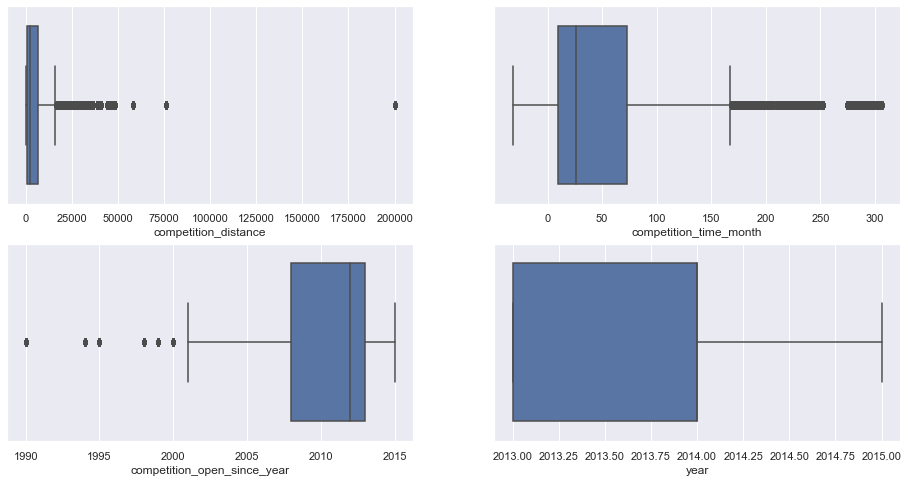

In [108]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance']);
plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month']);
plt.subplot(2,2,3)
sns.boxplot(df5['competition_open_since_year']);
plt.subplot(2,2,4)
sns.boxplot(df5['year']);

In [109]:
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

df5['promo2_since_year'] = mms.fit_transform( df5[['promo2_since_year']].values )

df5['competition_open_since_year'] = mms.fit_transform( df5[['competition_open_since_year']].values )


## 5.3 Transformation

In [110]:
# # One Hot Encoding
# state_holiday 
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])


# promo interval
df5 = pd.get_dummies(df5, prefix = ['promo_interval'], columns = ['promo_interval'])

# # Ordinal Encoding
# assortment
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

# # Label Encoding
# store_type
le = LabelEncoder()
le_store_type = le.fit(df5['store_type'])
df5['store_type'] = le_store_type.transform(df5['store_type'])
#pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))



## 5.4 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

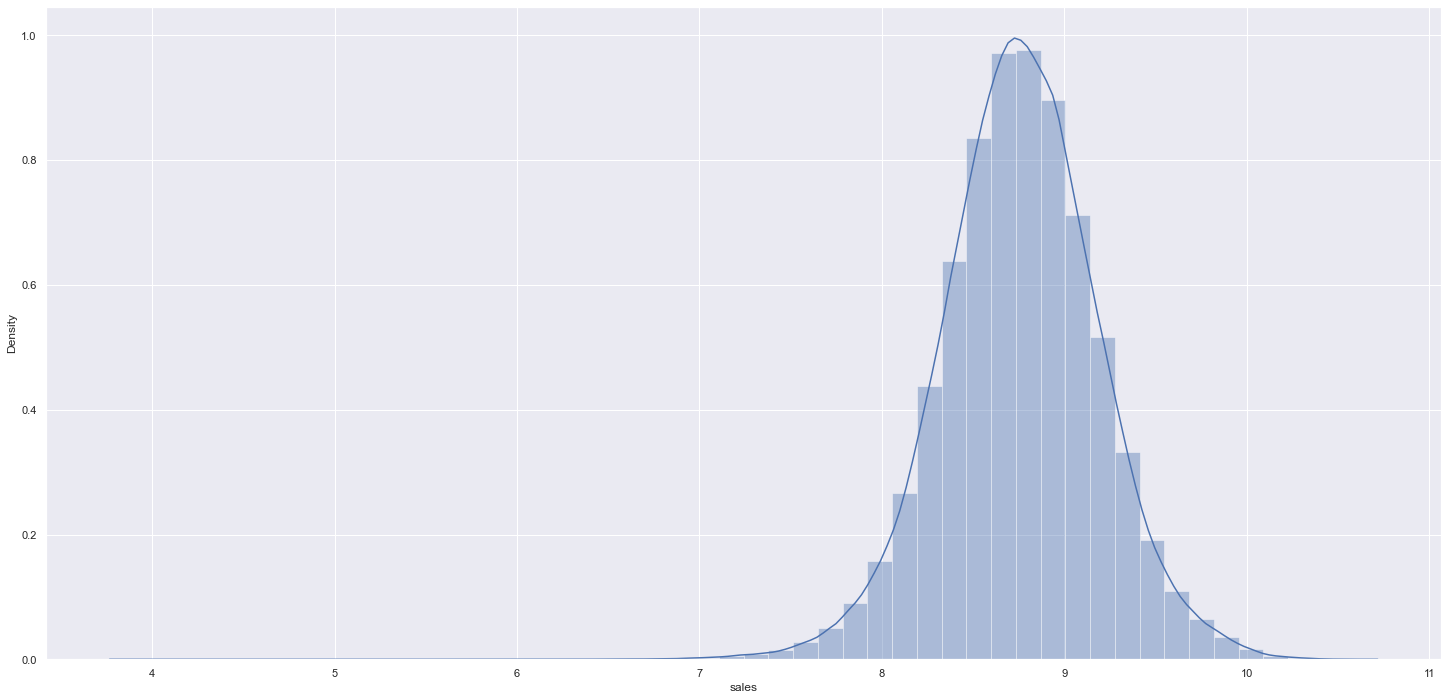

In [111]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales'])

## 5.5 Nature Transformation

In [112]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [113]:
# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply(lambda x: np.cos(x*(2*np.pi/52)))

#competition_open_since_month
df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# 6. Feature Selection

In [157]:
df6 = df5.copy()
df6.columns

Index(['store', 'day_of_week', 'date_x', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'date_y',
       'promo2_first_month', 'year', 'month', 'day', 'week_of_year',
       'year_week', 'competition_since', 'competition_time_month',
       'state_holiday_christmas', 'state_holiday_easter_holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'promo_interval_0', 'promo_interval_Feb,May,Aug,Nov',
       'promo_interval_Jan,Apr,Jul,Oct', 'promo_interval_Mar,Jun,Sept,Dec',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos',
       'promo2_since_week_sin', 'promo2_since_week_cos',
       'competition_open_since_month_sin', 'competition_open_since_month_cos'],
      dtype='object')

## 6.1 Splitting Data

To avoid overfitting in our model, we'll separate the last 6 weeks of our dataset for test and all the rest of the data for training.

In [158]:
cols_drop = ['month', 'competition_open_since_month', 'promo2_since_week', 'day', 'week_of_year','day_of_week', 'competition_since','date_y','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [159]:
# converts do datetime64
df6['date'] = pd.to_datetime(df6['date_x'])

# gets the first sales dates for each store
df6[['store','date']].groupby('store').min().reset_index()

# gets the last sales dates for each store
df6[['store','date']].groupby('store').max().reset_index()

# gets the date before the last 6 weeks of sales for each store
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [160]:
# creates the training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']
x_training = X_train #for cross validation

# creates the test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

# checking the operations
print('Traning Min Date: {}'.format(X_train['date'].min()))
print('Traning Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Traning Min Date: 2013-01-01 00:00:00
Traning Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [161]:
X_train_with_date = X_train.drop(['sales'], axis=1)
X_test_with_date = X_test.drop(['sales'], axis=1)

In [162]:
X_train = X_train.drop(['date', 'date_x','sales'], axis=1)
X_test = X_test.drop(['date', 'date_x','sales'], axis=1)

## 6.2 Boruta

In [139]:
# define traning and test data for Boruta
#X_train_boruta = X_train.values
#Y_train_boruta = Y_train.values.ravel()

# define RandomForestRegressor
# uses all cores from CPU (n_jobs=-1)
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_boruta, Y_train_boruta)


In [140]:
# # gets the ranked list of features
#cols_selected = boruta.support_.tolist()

In [141]:
# # get best features (only columns) as a list
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta
#[
# 'promo',
# 'store_type',
# 'assortment',
# 'competition_distance',
# 'competition_open_since_year',
# 'promo2_since_year',
# 'competition_time_month',
# 'promo_interval_Mar,Jun,Sept,Dec',
# 'day_of_week_sin',
# 'day_of_week_cos',
# 'month_cos',
# 'day_sin',
#'day_cos',
# 'week_of_year_cos',
# 'promo2_since_week_sin',
#'promo2_since_week_cos',
# 'competition_open_since_month_sin',
# 'competition_open_since_month_cos']

[
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2_since_year',
 'competition_time_month',
 'promo_interval_Mar,Jun,Sept,Dec',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos']

In [142]:
# bypasses the Boruta lenghty calculations
cols_selected_boruta = ['store', 'promo', 'store_type',
                       'assortment','competition_distance', 'competition_open_since_month',
                       'competition_open_since_year','promo2', 'promo2_since_week_sin',
                       'promo2_since_year','competition_time_month', 'promo2_since_week_cos'
                       'day_of_week_sin','day_of_week_cos', 'month_sin','month_cos',
                       'day_sin','day_cos', 'week_of_year_sin', 'week_of_year_cos']

## 6.3 Manual Features Selection

### 6.3.1 Random Forest

In [144]:
rf = RandomForestRegressor()
rf.fit(X_train,Y_train)
rf.feature_importances_

array([1.46143716e-01, 1.62232079e-01, 2.73917234e-03, 2.46079930e-02,
       2.44700240e-02, 1.76528730e-01, 5.75277920e-02, 1.94558975e-03,
       3.06191070e-02, 1.33081404e-03, 5.13451924e-03, 4.58119629e-02,
       1.70725050e-05, 3.99384743e-05, 2.19411688e-04, 1.32817663e-03,
       2.27520634e-03, 4.24547579e-03, 6.62227173e-03, 7.30707797e-03,
       3.83269498e-02, 4.06275287e-02, 4.50805814e-03, 1.99837777e-02,
       2.01018591e-02, 2.46050821e-02, 1.04598058e-02, 1.49650029e-02,
       2.32488275e-02, 2.28093860e-02, 4.43243556e-02, 3.48932361e-02])

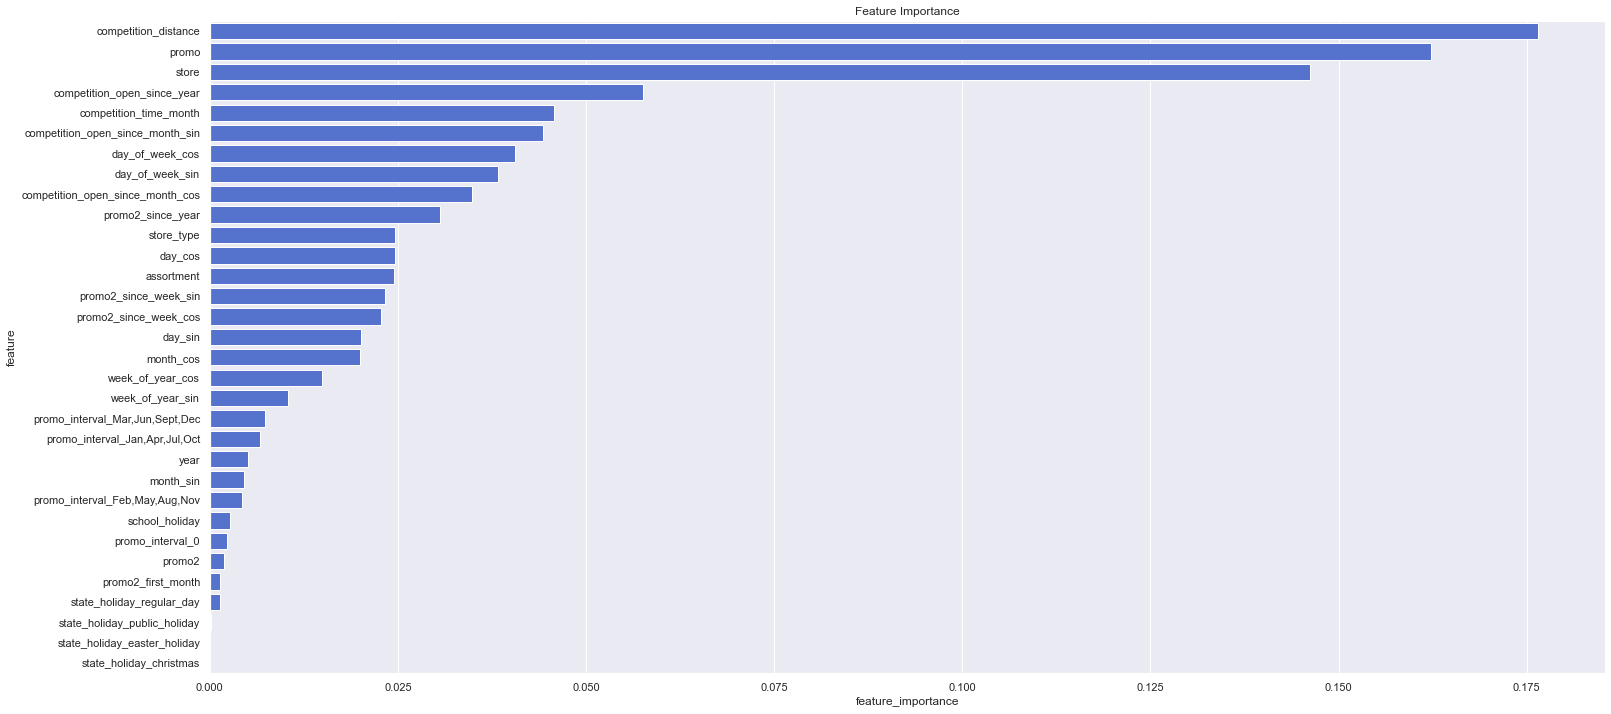

In [145]:
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)

sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

# 7. Machine Learning Modelling

In [147]:
df7 = df6.copy()

In [152]:
x_train = X_train [['store', 'promo', 'store_type',
  'assortment','competition_distance', 'competition_time_month',
  'competition_open_since_year','promo2', 'promo2_since_week_sin',
  'promo2_since_year', 'promo2_since_week_cos',
  'day_of_week_sin','day_of_week_cos', 'month_sin','month_cos',
  'day_sin','day_cos', 'week_of_year_sin', 'week_of_year_cos']]

x_test = X_test [['store', 'promo', 'store_type',
  'assortment','competition_distance', 'competition_time_month',
  'competition_open_since_year','promo2', 'promo2_since_week_sin',
  'promo2_since_year', 'promo2_since_week_cos',
  'day_of_week_sin','day_of_week_cos', 'month_sin','month_cos',
  'day_sin','day_cos', 'week_of_year_sin', 'week_of_year_cos']]

x_test_copy = x_test.copy()
x_test_copy['sales'] = Y_test.copy()

## 7.1 Average Model - Baseline

In [153]:
# prediction
# gets the mean sales by store
df_mean_sales_by_store = x_test_copy[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

# merges the datasets
x_test_copy = pd.merge(x_test_copy, df_mean_sales_by_store, how='left', on='store')

# estimates : baseline
yhat_baseline = x_test_copy['predictions']


# performance
# calculates the performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,"1,355.013811",0.433266,"1,835.498620"


## 7.2 Linear Regression Model

In [154]:
# model
lr = LinearRegression().fit(x_train, Y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,"1,871.275891",0.294530,"2,673.814308"


In [163]:
# makes the cross validation
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=True)

# checks the results
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2066.15 +- 305.94,0.29 +- 0.01,2955.39 +- 474.44


The RMSE from the Linear Regression model (2666) is higher than the RMSE from Average model (1871). This allow us to infer that the relation between the variables is non linear

## 7.3 Linear Regression Regularized LASSO Model

In [166]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,"1,900.813997",0.288423,"2,768.994127"


In [167]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2128.14 +- 368.79,0.3 +- 0.01,3065.92 +- 550.51


## 7.4 Random Forest Regressor Model

In [168]:
# model
# 100 trees
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,665.891969,0.098136,992.367487


In [169]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,800.68 +- 229.23,0.11 +- 0.03,1185.23 +- 344.35


## 7.5 XGBoost Regressor

In [170]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', # we're solving a regression problem
                             n_estimators=100, 
                             eta=0.01, 
                             max_depth=10,  # max depth of the tree
                             subsample=0.7, # percentage os variables to be selected
                             colsample_bytree=0.9).fit(x_train, Y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,"6,684.961557",0.949816,"7,332.540879"


In [171]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7048.75 +- 589.42,0.95 +- 0.0,7715.02 +- 690.27


In [172]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(iterations=15,
                          learning_rate=0.5,
                          depth=10)
# Fit model
model_cat.fit(x_train, Y_train)

# Get predictions
yhat_cat = model_cat.predict(x_test)

# performance
cat_result = ml_error('CatBoost Regressor', np.expm1(Y_test), np.expm1(yhat_cat))
cat_result

0:	learn: 0.3700846	total: 239ms	remaining: 3.34s
1:	learn: 0.3479095	total: 412ms	remaining: 2.68s
2:	learn: 0.3307490	total: 610ms	remaining: 2.44s
3:	learn: 0.3244903	total: 799ms	remaining: 2.2s
4:	learn: 0.3198630	total: 1.02s	remaining: 2.04s
5:	learn: 0.3092911	total: 1.25s	remaining: 1.87s
6:	learn: 0.2955212	total: 1.47s	remaining: 1.68s
7:	learn: 0.2870621	total: 1.66s	remaining: 1.46s
8:	learn: 0.2821388	total: 1.85s	remaining: 1.23s
9:	learn: 0.2794912	total: 2.03s	remaining: 1.02s
10:	learn: 0.2729997	total: 2.23s	remaining: 810ms
11:	learn: 0.2640544	total: 2.42s	remaining: 605ms
12:	learn: 0.2547505	total: 2.6s	remaining: 400ms
13:	learn: 0.2470696	total: 2.8s	remaining: 200ms
14:	learn: 0.2410687	total: 2.98s	remaining: 0us


,Model Name,MAE,MAPE,RMSE
0,CatBoost Regressor,"1,287.963108",0.186529,"1,877.758487"


In [173]:
cat_result_cv = cross_validation(x_training, 5, 'CatBoost Regressor', model_cat, verbose=True)
cat_result_cv


KFold Number: 5
0:	learn: 0.3631924	total: 153ms	remaining: 2.14s
1:	learn: 0.3374511	total: 302ms	remaining: 1.97s
2:	learn: 0.3263933	total: 462ms	remaining: 1.85s
3:	learn: 0.3075650	total: 649ms	remaining: 1.78s
4:	learn: 0.3015643	total: 867ms	remaining: 1.73s
5:	learn: 0.2792970	total: 1.03s	remaining: 1.55s
6:	learn: 0.2701218	total: 1.19s	remaining: 1.36s
7:	learn: 0.2591967	total: 1.36s	remaining: 1.19s
8:	learn: 0.2528253	total: 1.55s	remaining: 1.03s
9:	learn: 0.2495209	total: 1.73s	remaining: 863ms
10:	learn: 0.2393658	total: 1.88s	remaining: 684ms
11:	learn: 0.2348321	total: 2.04s	remaining: 510ms
12:	learn: 0.2297629	total: 2.2s	remaining: 338ms
13:	learn: 0.2212092	total: 2.35s	remaining: 168ms
14:	learn: 0.2177399	total: 2.52s	remaining: 0us

KFold Number: 4
0:	learn: 0.3708365	total: 157ms	remaining: 2.19s
1:	learn: 0.3496716	total: 319ms	remaining: 2.07s
2:	learn: 0.3283256	total: 486ms	remaining: 1.94s
3:	learn: 0.3195130	total: 648ms	remaining: 1.78s
4:	learn: 0.29

,Model Name,MAE CV,MAPE CV,RMSE CV
0,CatBoost Regressor,1347.14 +- 245.16,0.19 +- 0.02,1935.4 +- 356.74


## Model Performances Comparison

In [174]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, cat_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,665.891969,0.098136,992.367487
0,Average Model,"1,355.013811",0.433266,"1,835.498620"
0,CatBoost Regressor,"1,287.963108",0.186529,"1,877.758487"
0,Linear Regression,"1,871.275891",0.294530,"2,673.814308"
0,Linear Regression - Lasso,"1,900.813997",0.288423,"2,768.994127"
0,XGBoost Regressor,"6,684.961557",0.949816,"7,332.540879"


In [175]:
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv, cat_result_cv])
modeling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,800.68 +- 229.23,0.11 +- 0.03,1185.23 +- 344.35
0,CatBoost Regressor,1347.14 +- 245.16,0.19 +- 0.02,1935.4 +- 356.74
0,Linear Regression,2066.15 +- 305.94,0.29 +- 0.01,2955.39 +- 474.44
0,Linear Regression - Lasso,2128.14 +- 368.79,0.3 +- 0.01,3065.92 +- 550.51
0,XGBoost Regressor,7048.75 +- 589.42,0.95 +- 0.0,7715.02 +- 690.27


# 8. Model Hyperparameter unning

## Random Search

In [176]:
# n_estimators: number of trees in the random forest (default=100)
n_estimators = [int(x) for x in np.linspace(start=100, stop=400, num=10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 30, 10)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
min_samples_leaf = [1, 2, 4]

# create random grid
param = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param)

{'n_estimators': [100, 133, 166, 200, 233, 266, 300, 333, 366, 400], 'max_depth': [4, 6, 9, 12, 15, 18, 21, 24, 27, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [177]:
# creates empty DataFrame to store the final results
#final_result = pd.DataFrame()
#MAX_EVAL = 5

#for i in range(MAX_EVAL):
    # randomly chooses values for parameters
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
    
    # model 
#    model_rf = RandomForestRegressor(n_estimators=hp['n_estimators'],
#                                    max_depth = hp['max_depth'],
#                                    min_samples_split = hp['min_samples_split'],
#                                    min_samples_leaf=hp['min_samples_leaf'],
#                                    n_jobs=-1, 
#                                    random_state=42).fit(x_train, Y_train)
    
    
        
    # performance
#    result = cross_validation(x_training, 5, 'Random Forest', model_rf, verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result

The model with default values of the Random Forest algorithm performed better and therefore will be used.

## Final Model

In [178]:
# final model
# 100 trees
rf_final = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf_final = rf_final.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf_final))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,665.891969,0.098136,992.367487


# 9. Business Performance 

We have to scalle the predictions back to the original scale.
We can also measure the Mean Percentage Error

In [179]:
# gets the test set - 6 weeks of test set
df9 = X_test_with_date

# scales back the data
df9['sales'] = np.expm1(Y_test)
df9['predictions'] = np.expm1(yhat_rf_final)

mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_rf_final))
mpe

-0.02279729423448587

## 9.1 Scenarios

In [180]:
# gets total sales predictions by store
df_predictions_by_store = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df_predictions_MAE = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df_predictions_MAPE = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merges
df_MAE_MAPE = pd.merge(df_predictions_MAE, df_predictions_MAPE, how='inner', on='store')
df_predictions_MAE_MAPE = pd.merge(df_predictions_by_store, df_MAE_MAPE, how='inner', on='store')

# creates scenarios
df_predictions_MAE_MAPE['worst_scenario'] = df_predictions_MAE_MAPE['predictions'] - df_predictions_MAE_MAPE['MAE']
df_predictions_MAE_MAPE['best_scenario'] = df_predictions_MAE_MAPE['predictions'] + df_predictions_MAE_MAPE['MAE']

# organize
df_predictions_MAE_MAPE = df_predictions_MAE_MAPE[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

#challenging stores
df_predictions_MAE_MAPE.sort_values('MAPE', ascending=False).head()


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
290,292,"111,329.659663","107,670.184560","114,989.134766","3,659.475103",0.643899
906,909,"257,145.756204","250,015.200251","264,276.312157","7,130.555953",0.519116
548,550,"263,196.956788","261,282.255253","265,111.658323","1,914.701535",0.384276
181,183,"230,653.001945","228,642.839299","232,663.164590","2,010.162646",0.358536
720,722,"370,234.678549","367,776.876426","372,692.480672","2,457.802123",0.334919


Each store has a prediction error. It is interesting to evaluate which stores have higher errors score and, therefore, are more challenging to predict.

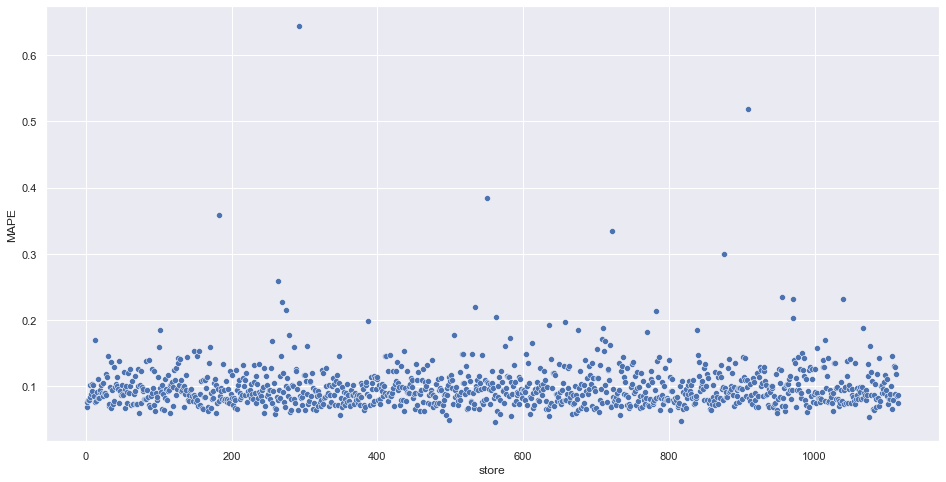

In [181]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 8)
ax = sns.scatterplot(x='store', y='MAPE', data=df_predictions_MAE_MAPE)

plt.show()

## 9.2. Total Performance (Total sales revenue for the next 6 weeks)

In [182]:
# gets the total sales by scenario
df_scenario_values = df_predictions_MAE_MAPE[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})

# formats the values to monetary
df_scenario_values['Values'] = df_scenario_values['Values'].map('US$ {:,.2f}'.format)

df_scenario_values

,Scenario,Values
0,predictions,"US$ 290,204,788.05"
1,worst_scenario,"US$ 289,459,451.78"
2,best_scenario,"US$ 290,950,124.32"


# 10. ML Performance

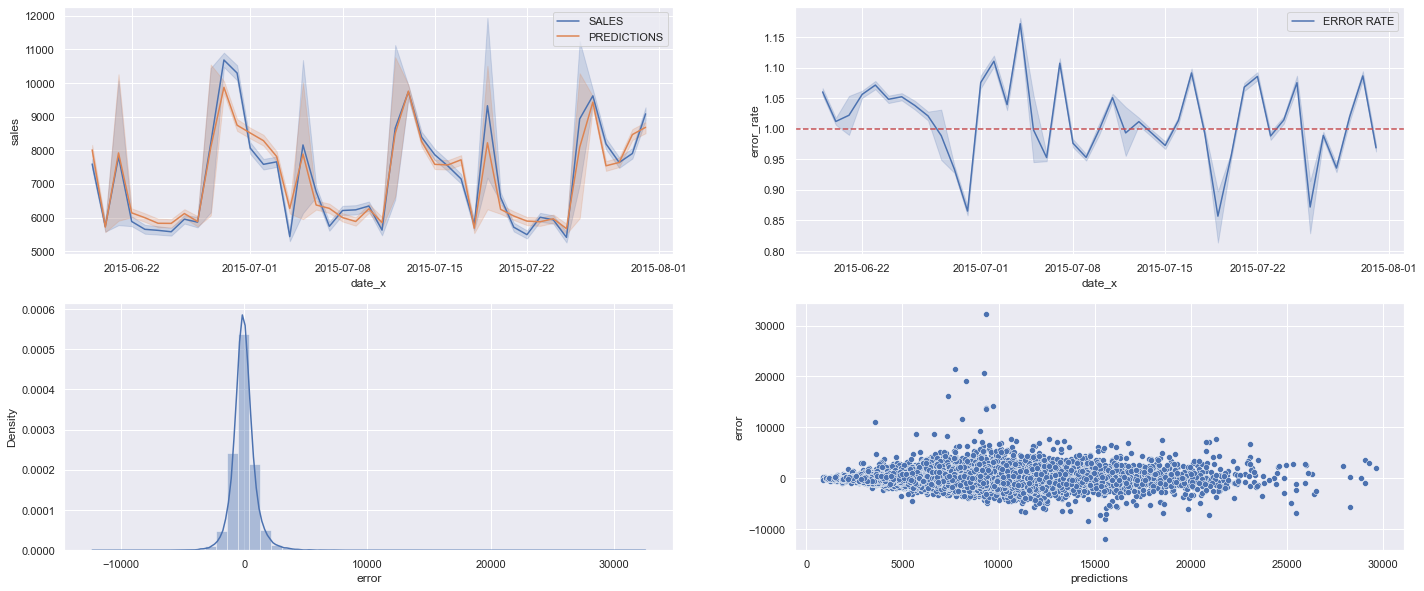

In [187]:
# gets the error
df9['error'] = df9['sales'] - df9['predictions']

# gets the error rate
df9['error_rate'] = df9['predictions'] / df9['sales']

fig, ax = plt.subplots()
ax.figure.set_size_inches(24, 10)
plt.subplot(2, 2, 1)
sns.lineplot(x='date_x', y='sales', data=df9, label='SALES')
sns.lineplot(x='date_x', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date_x', y='error_rate', data=df9, label='ERROR RATE')
plt.axhline(1, linestyle='--', color='r')


# PLOTS FOR RESIDUAL ANALYSIS
plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])


# displays the plot
plt.show()

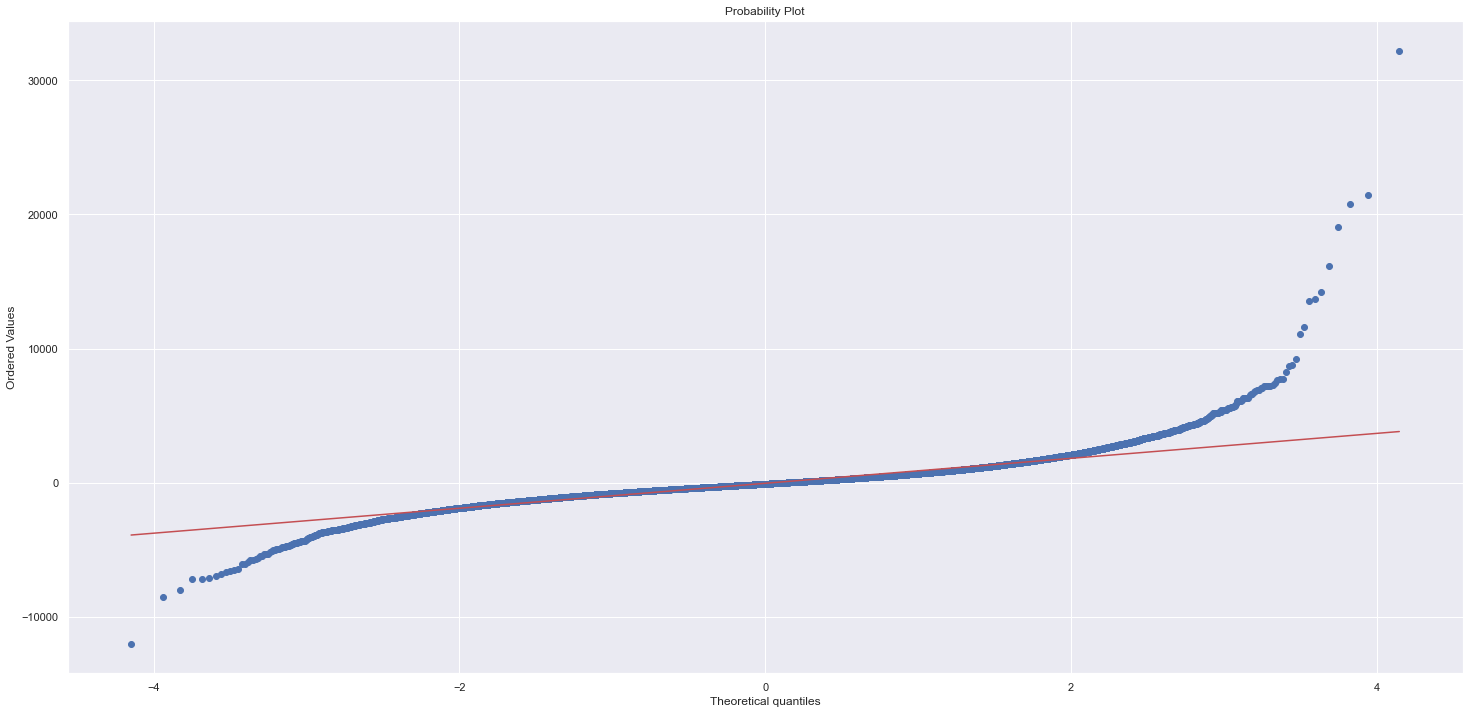

In [184]:
stats.probplot(df9['error'], plot=plt);

The line plots allow us to evaluate the errors. In the first graph, we can see that the predictions are close to the real value for sales. 
On the other hand, the error rate has some variance, with some peaks that should be addressed.

The histogram shows that the error distribution is almost normal.

In the residual analysis, we can see in the scatterplot that the points look loke an horizontal tube which means that there's a few variation in the error. If the points formed any other shape as an opening/closing cone or an arch, this would mean that the errors follows a trend and we would need to review our model.